## Análisis De Canciones para la banda The Beatles

### Preparación para el análisis

In [1]:
#Importando todo lo necesario para el proyecto
import pandas as pd
import numpy as np
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords  
import lyricsgenius as genius
import sys
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import PorterStemmer
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from collections import Counter
from os import path
from PIL import Image
from keras.models import model_from_json
pd.options.mode.chained_assignment = None
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'png'

In [2]:
import lyricsgenius as genius #Letras y artista
import spotipy #Para obtener la fecha de lanzamiento

from spotipy.oauth2 import SpotifyClientCredentials #Autenticación para Spotify
client_id = 'bdd8236cedd64c3fba1c272816f56da1' #Datos para usar el API de Spotify
client_secret = '1addbbc66511419d86b0921906a421f8'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #Objeto para entrar al API

In [3]:
#Bibliotecas utilizadas para extraer, limpiar y manipular la información 
import requests

#Para generar gráficas
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#Biblioteca para el conteo de frecuencia de palabras
from sklearn.feature_extraction.text import CountVectorizer

#Para crear el modelo de análisis de sentimientos, creación de tokens y de lemas
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
import nltk.data

### Funciones

In [4]:
#Para obtener los datos de Genius acerca de las canciones
def search_data(query,n,access_token):
    
    #Se agrega retraso, timeout y reintentos en la consulta de datos, para prevenir fallas de obtención de información
    api = genius.Genius("h82-IfEGZrSxMbfHVq2kEvCIMWKR6-_5YI-gnKT39g2EE_PJBTS_Gxc0RQsnqFO7",sleep_time=0.01, timeout=15, retries = 3, verbose=True)

    list_lyrics = []
    list_title = []
    list_artist = []
    list_album = []
    list_year = []

    artist = api.search_artist(query,max_songs=n,sort='popularity') #Genius, se obtienen canciones del artista por popularidad
    songs = artist.songs #Son las canciones
    #print(songs)
    #print(songs[0].stats)
    for song in songs:
        result = sp.search(q="artist:" + song.artist + " track:" + song.title, type="track", limit="1") #Consulta a Spotipy
        #print("#################################### SONG " + song.title + " ######################################")
        #print(result['tracks']['items'])
        if(result['tracks']['items'] == []):
            list_year.append('1950') #Los que no tienen fecha, se van a 1950
        else:
            release_date = result['tracks']['items'][0]['album']['release_date'][:4] #Añade la fecha del primer resultado
            list_year.append(release_date)
            
        list_lyrics.append(song.lyrics)
        list_title.append(song.title)
        list_artist.append(song.artist)

    df = pd.DataFrame({'artist':list_artist,'title':list_title,
                        'date':list_year,'lyric':list_lyrics})
    
    return df

In [5]:
#Esta función realiza la limpieza de las letras quitando las palabras que no aportan nada al análisis
def clean_lyrics(df,column):

    df = df
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro|[0-9]|verse|prechorus|interlude","", regex=True).str.replace("[","", regex=True).str.replace("]","", regex=True)
    df[column] = df[column].str.lower().str.replace(r"instrumental|intro|solo|embedshare|urlcopyembedcopy|,","", regex=True)
    df[column] = df[column].str.replace("\n"," ", regex=True).str.replace(r"[^\w\d'\s]+","", regex=True)
    df[column] = df[column].str.replace(r"paul mccartney|mccartney|john lennon|lennon|george harrison|harrison|ringo starr|starr|billy preston|preston|paul|john|george|ringo|naa|jude|judy|i've|i'm|she's|he's|you've","", regex=True)
    df[column] = df[column].str.replace(r"aaah|aah|ahhahahah|ahahah|ahahahh|mmmmmmmmmmmmmmm|hmmhmm|doo da doo doo|hela heba helloa hela heba helloa cha cha cha hela heba helloa woo hela heba helloa hela hela heba helloa cha cha cha hela heba helloa woohoo hela heba helloa cha cha cha hela heba helloa cha cha cha|mmmmmmmmmmmmmmm hmmhmm|oh      yeah yeah yeah yeah yeah yeah yeah  na na na na na na na na na na hey   na na na na na na na na na na hey   na na na na na na na na na na hey   na na na na na na na na na na hey        ow wow  na na na na na na na na na na na na na hey        na na na na na na yeah yeah yeah na na na na hey  you know you can make   you're not gonna break it  na don't make it bad  na na na na na take a sad song and make it better na na na na hey  hey  hey  wow  na na na na na na na na na na hey   na na na na na na na na na na hey         na na na na na na na na na na hey   na na na na na na na na na na hey  na na na na na na na na na na na na  na na na na na na na na na na hey   na na na na na na na na na na hey   na na na na na na make it  na na na na hey  yeah yeah yeah yeah yeah yeah yeah  na na na na na na na na na na hey  go listen to ya ma ma ma ma ma ma ma ma  na na na na na na na na na na hey   na na na na na na na na na na hey|goo goo goo joob good pity g'goo goo g'joob|goo goo g'joob g'goo goo g'joob goo goo a'joob g'goo goo g'joob g'goo joob joob joob   joob joob joob joob joob joob joob joob joob joob joob joob   umpa umpa|sha la la la la la la|mmm|hmm|oh oh oh oh oh oh oh oh oh oh oh oh oh  yeah yeah yeah yeah yeah yeah yeah yeah yeah oh ooh","", regex=True)
    df[column] = df[column].str.replace(r"jai guru deva jai guru deva jai guru deva jai guru deva jai guru deva jai guru deva|jai guru deva om|segue      |mimimimimimimimimind|do do do do do do oh yeah|ooh oh yeah|yeah yeah yeah|o o o|whoa whoa whoaoa dododododo|drum  guitar s   break|tit tit tit tit tit tit tit tit|tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit tit|tit tit tit tit tit tit tit tit|mm mm mm mm mm mm mm mm mm da da da da da da da|heh heh heh oh|chachachachance|ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da ah da|na na na na na na na na na na na na|ah ho ha ha ha ha ha ha|wahoo woof|wooaah ha ha ha|iimememine|didididi'n'di|oooooo|ohohohohohoh|da da da da da dum dum da da da da da da dum dum da|   h   |na na na na na na na na na yeah|na na na na na na na na na na|goo goo a'joob  |ahh  |sont des mots qui vont très bien ensemble très bien ensemble|oh oh oh oh|dododododo clang clang|soooo|piccolo trumpet     with|ooh no  |oh oh no|electric piano    |  spoken |  ahah ah ahhah ahhahah  ah ahh ahh ahh ahh ahah ahh|ooo   ooo ow|yeah","", regex=True)
    df[column] = df[column].str.strip()

    return df

In [6]:
#Esta función divide las letras en palabras, remueve stopwords en inglés y crea el lema de cada palabra
def lyrics_to_words(document):
    
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    
    return normalized

In [7]:
#Crea una nueva columna llamada "Decadas" utilizada para agrupar las canciones y letras por decada basado en su fecha de lanzamiento
#Nota: las canciones que no tienen registro de fecha de lanzamiento se registran en la década de los 50's
def create_decades(df):

    decades = []
    df['date'].fillna(0)
    df['date'] = df['date'].astype("int")

    for year in df['date']:
        if 1950 <= year < 1960:
            decades.append("50s")
        if 1960 <= year < 1970:
            decades.append("60s")
        if 1970 <= year < 1980:
            decades.append("70s")
        if 1980 <= year < 1990:
            decades.append("80s")
        if 1990 <= year < 2000:
            decades.append("90s")
        if 2000 <= year < 2010:
            decades.append("00s")
        if 2010 <= year :
            decades.append("10s")
    df['decade'] = decades
    df = df[['artist','title','decade','date','lyric']]
    
    return df

In [8]:
#Función para crear una gráfica con el resumen por año de las canciones
def plot_year_counts(dataset, X, y, title):

    characteristics = dataset.groupby(X).count()
    mpl.rcParams['figure.figsize'] = (35,10,)
    #all_songs.groupby('Year').count().plot(kind='bar')
    sns.barplot(y=characteristics[y], x=characteristics.index)
    plt.title(title)
    plt.ylabel("Number of Songs")
    plt.xticks(rotation=90)

In [9]:
#Añade los verbos, adverbios, sustantivos al dataset y genera el corpus de las canciones
def add_spacy_data(dataset, feature_column):
    
    verbs = []
    nouns = []
    adverbs = []
    corpus = []
    nlp = spacy.load('en_core_web_sm') #Se utiliza este modelo
    
    for i in range (0, len(dataset)):
        print("Extracting verbs and topics from record {} of {}".format(i+1, len(dataset)), end = "\r")
        song = dataset.iloc[i][feature_column]
        doc = nlp(song)
        spacy_dataframe = pd.DataFrame()
        for token in doc:
            if token.lemma_ == "-PRON-":
                    lemma = token.text
            else:
                lemma = token.lemma_
            row = {
                "Word": token.text,
                "Lemma": lemma,
                "PoS": token.pos_,
                "Stop Word": token.is_stop
            }
            spacy_dataframe = spacy_dataframe.append(row, ignore_index = True)
        verbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "VERB"].values))
        nouns.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "ADV"].values))
        corpus_clean = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["Stop Word"] == False].values)
        corpus_clean = re.sub(r'[^A-Za-z0-9]+', ' ', corpus_clean)   
        corpus.append(corpus_clean)
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Corpus'] = corpus
    
    return dataset

In [10]:
#Permite crear la nube de palabras
def wordcloud(text, max_words):
    
    wordcloud = WordCloud(
                          width = 4000,
                          height = 3000,
                          background_color="white",
                          max_words = max_words                          
                         ).generate(text)
    plt.figure(figsize=(40,25))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
    return;

In [11]:
#Crea un nuevo dataset con la frecuencia de las palabras 
def map_popular_terms(dataset, feature_column, year_column):

    frequencies = pd.DataFrame()
    years = dataset[year_column].unique().tolist()
    for i in range (0, len(years)):
        year_corpus = str(dataset[feature_column][dataset[year_column] == years[i]].tolist())
        tokens = year_corpus.split(" ")
        counts = Counter(tokens)
        frequencies = frequencies.append({
            "Year": years[i],
            "Most Common Terms": counts.most_common(n=100)
        }, ignore_index=True)
    frequencies['Year'] = frequencies['Year'].astype(int)
    
    return frequencies
    

In [12]:
#Obtiene palabras comunes en diferentes columnas
def map_common_words(dataset):

    common_words = []
    for words in dataset['Most Common Terms'][0]:
        common_words.append(words[0])

    for i in range (0, 5):
        check_list = []
        year_list = dataset['Most Common Terms'][i]
        for words in year_list:
            check_list.append(words[0])
        common_words = [x for x in common_words if x  in check_list]
        print(common_words)
        
    return common_words

In [13]:
#Obtiene la frecuencia de las palabras y las organiza por año
def get_common_frequency(term_list, frequency_list):
    '''Finds the frequency of occurence of terms in a list and then
    returns them in a new dataframe organized by year'''
    common_word_frequency_per_year = pd.DataFrame()
    for i in range(0, len(term_list)):
        word_frequency = []
        for j in range(0, len(frequency_list)):
            current_year = frequency_list['Year'][j]
            current_year_terms = frequency_list['Most Common Terms'][j]
            for words in current_year_terms:
                    if term_list[i] in words[0]:
                        word_frequency.append(words[1])
                        #print(words[1])
                        break
        current_word = term_list[i]
        print(current_word)
        common_word_frequency_per_year[str(current_word)] = pd.Series(word_frequency)
    print(common_word_frequency_per_year)
    common_word_frequency_per_year["Year"] = frequency_list['Year']
    common_word_frequency_per_year = common_word_frequency_per_year.set_index("Year")
    return common_word_frequency_per_year

### Recolección e interpretación de datos

In [14]:
#Extrae la información de las 150 canciones más populares de The Beatles
#Se hace uso de genius y spotify
access_token = 'h82-IfEGZrSxMbfHVq2kEvCIMWKR6-_5YI-gnKT39g2EE_PJBTS_Gxc0RQsnqFO7'

df0 = search_data('The Beatles',150,access_token)

Searching for songs by The Beatles...

Song 1: "Let It Be"
Song 2: "Yesterday"
Song 3: "Come Together"
Song 4: "Hey Jude"
Song 5: "Here Comes the Sun"
Song 6: "Something"
Song 7: "A Day in the Life"
Song 8: "Blackbird"
Song 9: "Eleanor Rigby"
Song 10: "I Am the Walrus"
Song 11: "In My Life"
Song 12: "While My Guitar Gently Weeps"
Song 13: "Across the Universe"
Song 14: "Lucy in the Sky with Diamonds"
Song 15: "With a Little Help from My Friends"
Song 16: "Strawberry Fields Forever"
Song 17: "Michelle"
Song 18: "Help!"
Song 19: "Ob-La-Di, Ob-La-Da"
Song 20: "I Want to Hold Your Hand"
Song 21: "Norwegian Wood (This Bird Has Flown)"
Song 22: "Yellow Submarine"
Song 23: "Don’t Let Me Down"
Song 24: "Rocky Raccoon"
Song 25: "When I’m Sixty-Four"
Song 26: "Oh! Darling"
Song 27: "Back in the U.S.S.R."
Song 28: "Happiness is a Warm Gun"
Song 29: "Golden Slumbers"
Song 30: "Sgt. Pepper’s Lonely Hearts Club Band"
Song 31: "She Loves You"
Song 32: "Helter Skelter"
Song 33: "Maxwell’s Silver Hamme

In [15]:
#Muestra la información completa del Dataset
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [16]:
#Nuestro Dataset es df0
#Sólo muestra la información de las primeras tres canciones
df0.head(3)

artist          title  date  \
0  The Beatles      Let It Be  1970   
1  The Beatles      Yesterday  1965   
2  The Beatles  Come Together  1969   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          lyric  
0                                                     [Verse 1]\nWhen I find myself in times of trouble, Mother Mary comes to me\nSpeaking words of wisdom, "Let it be"\nAnd in my hour of darkness, she is standing right in front of me\nSpeaking words of wisdom, "Let it be"\n\n[Chorus]\nLet it be, let it be, let it be, let it be\nWhisper words of wisdom, let it be\n\n[Verse 2]\nAnd when the brokenhearted people living in the world agree\nThere will be an answer, let it be\nFor though they may be parted, there is still a chance that they will see\nThere will be an answer, let it be\n\n[Chorus]\nLet it be, let it be, let it be, let it be\nYeah, there will be an answer, let it be\nLet it be, let it be, let it be, let it be\nWhisper words of wisdom, let it be\n[Instrumental Bridge]\n\n[Chorus]\nLet it be, let it be, let it be, yeah, let it be\nWhisper words of wisdom, let it be\n[Verse 3]\nAnd when the night is cloudy, there is still a light that shines on me\nShine on 'til tomorrow, let it be\nI wake up to the sound of music, Mother Mary comes to me\nSpeaking words of wisdom, "Let it be"\n\n[Chorus]\nLet it be, let it be, let it be, yeah, let it be\nOh, there will be an answer, let it be\nLet it be, let it be, let it be, yeah, let it be\nOh, there will be an answer, let it be\nLet it be, let it be, let it be, yeah, let it be\nWhisper words of wisdom, let it be115EmbedShare URLCopyEmbedCopy  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [Verse 1]\nYesterday\nAll my troubles seemed so far away\nNow it looks as though they're here to stay\nOh, I believe in yesterday\n\n[Verse 2]\nSuddenly\nI'm not half the man I used to be\nThere's a shadow hanging over me\nOh, yesterday came suddenly\n\n[Chorus]\nWhy she had to go\nI don't know, she wouldn't say\nI said something wrong\nNow I long for yesterday\n\n[Verse 3]\nYesterday\nLove was such an easy

In [17]:
#Muestra la letra de la primera canción (sin procesar)
df0['lyric'][0]

'[Verse 1]\nWhen I find myself in times of trouble, Mother Mary comes to me\nSpeaking words of wisdom, "Let it be"\nAnd in my hour of darkness, she is standing right in front of me\nSpeaking words of wisdom, "Let it be"\n\n[Chorus]\nLet it be, let it be, let it be, let it be\nWhisper words of wisdom, let it be\n\n[Verse 2]\nAnd when the brokenhearted people living in the world agree\nThere will be an answer, let it be\nFor though they may be parted, there is still a chance that they will see\nThere will be an answer, let it be\n\n[Chorus]\nLet it be, let it be, let it be, let it be\nYeah, there will be an answer, let it be\nLet it be, let it be, let it be, let it be\nWhisper words of wisdom, let it be\n[Instrumental Bridge]\n\n[Chorus]\nLet it be, let it be, let it be, yeah, let it be\nWhisper words of wisdom, let it be\n[Verse 3]\nAnd when the night is cloudy, there is still a light that shines on me\nShine on \'til tomorrow, let it be\nI wake up to the sound of music, Mother Mary com

In [18]:
#Limpiando las letras de las canciones utilizando las funciones anteriormente creadas
df0 = clean_lyrics(df0,'lyric')
df0 = create_decades(df0)
#Se imprimen las letras después de la limpieza de datos
#df0['lyric']

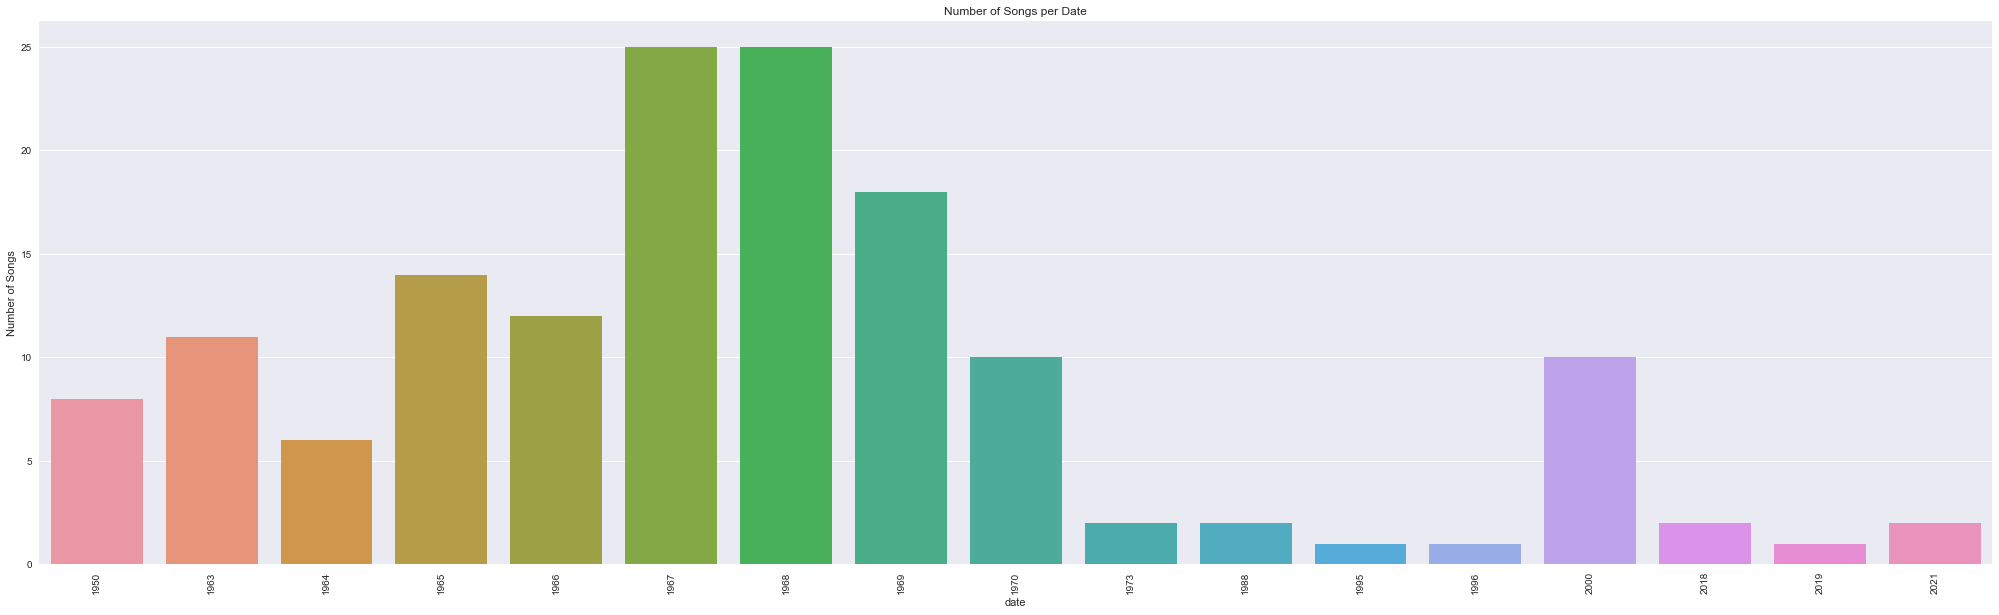

In [19]:
#Gráfica de canciones por año 
plot_year_counts(df0, 'date', 'title', "Number of Songs per Date")
plt.show()

In [20]:
#Guardando información del dataframe en un csv y en un json
df0.to_csv("all_songs_data.csv")
df0.to_json("all_song_data.json", orient='records')

In [21]:
#Leyendo csv
loaded_song_dataset = pd.read_csv("all_songs_data.csv",index_col=0)

In [22]:
#Mostrando información del csv (primeras tres canciones)
display(loaded_song_dataset.head(3))

artist          title decade  date  \
0  The Beatles      Let It Be    70s  1970   
1  The Beatles      Yesterday    60s  1965   
2  The Beatles  Come Together    60s  1969   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           lyric  
0  when i find myself in times of trouble mother mary comes to me speaking words of wisdom let it be and in my hour of darkness she is standing right in front of me speaking words of wisdom let it be   let it be let it be let it be let it be whisper words of wisdom let it be   and when the brokenhearted people living in the world agree there will be an answer let it be for though they may be parted there is still a chance that they will see there will be an answer let it be   let it be let it be let it be let it be  there will be an answer let it be let it be let it be let it be let it be whisper words of wisdom let it be     let it be let it be let it be  let it be whisper words of wisdom let it be  and when the night is cloudy there is still a light that shines on me shine on 'til tomorrow let it be i wake up to the sound of music mother mary comes to me speaking words of wisdom let it be   let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be whisper words of wisdom let it be  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  yesterday all my troubles seemed so far away now it looks as though they're here to stay oh i believe in yesterday   suddenly  not half the man i used to be there's a shadow hanging over me oh yesterday came suddenly   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday   yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday  yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday  
2                                  shoot me shoot me shoot me shoot me   here come old flattop he come groovin' up slowly he got juju eyeball he one holy roller he got hair down to his knee got to be a joker he just do what he please   shoot me shoot me shoot me shoot me   he wear no shoeshine he got toejam football he got monkey finger he shoot cocacola he say i know you you know me one thing i can tel

### Eliminando canciones sin contenido lírico. 


Para la banda elegida no hay canciones sin letras, pero esta parte se agrega en caso de que en un futuro querramos analizar a un artista que sí tenga piezas instrumentales. 

In [23]:
#Eliminando canciones sin letra 
songs_with_lyrics_dataset = loaded_song_dataset.dropna(subset=['lyric'])

In [24]:
#150 canciones y 5 columnas
songs_with_lyrics_dataset.shape

(150, 5)

In [25]:
#Mostrando primeros tres elementos del dataset
songs_with_lyrics_dataset.head(3)

artist          title decade  date  \
0  The Beatles      Let It Be    70s  1970   
1  The Beatles      Yesterday    60s  1965   
2  The Beatles  Come Together    60s  1969   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           lyric  
0  when i find myself in times of trouble mother mary comes to me speaking words of wisdom let it be and in my hour of darkness she is standing right in front of me speaking words of wisdom let it be   let it be let it be let it be let it be whisper words of wisdom let it be   and when the brokenhearted people living in the world agree there will be an answer let it be for though they may be parted there is still a chance that they will see there will be an answer let it be   let it be let it be let it be let it be  there will be an answer let it be let it be let it be let it be let it be whisper words of wisdom let it be     let it be let it be let it be  let it be whisper words of wisdom let it be  and when the night is cloudy there is still a light that shines on me shine on 'til tomorrow let it be i wake up to the sound of music mother mary comes to me speaking words of wisdom let it be   let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be whisper words of wisdom let it be  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  yesterday all my troubles seemed so far away now it looks as though they're here to stay oh i believe in yesterday   suddenly  not half the man i used to be there's a shadow hanging over me oh yesterday came suddenly   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday   yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday  yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday  
2                                  shoot me shoot me shoot me shoot me   here come old flattop he come groovin' up slowly he got juju eyeball he one holy roller he got hair down to his knee got to be a joker he just do what he please   shoot me shoot me shoot me shoot me   he wear no shoeshine he got toejam football he got monkey finger he shoot cocacola he say i know you you know me one thing i can tel

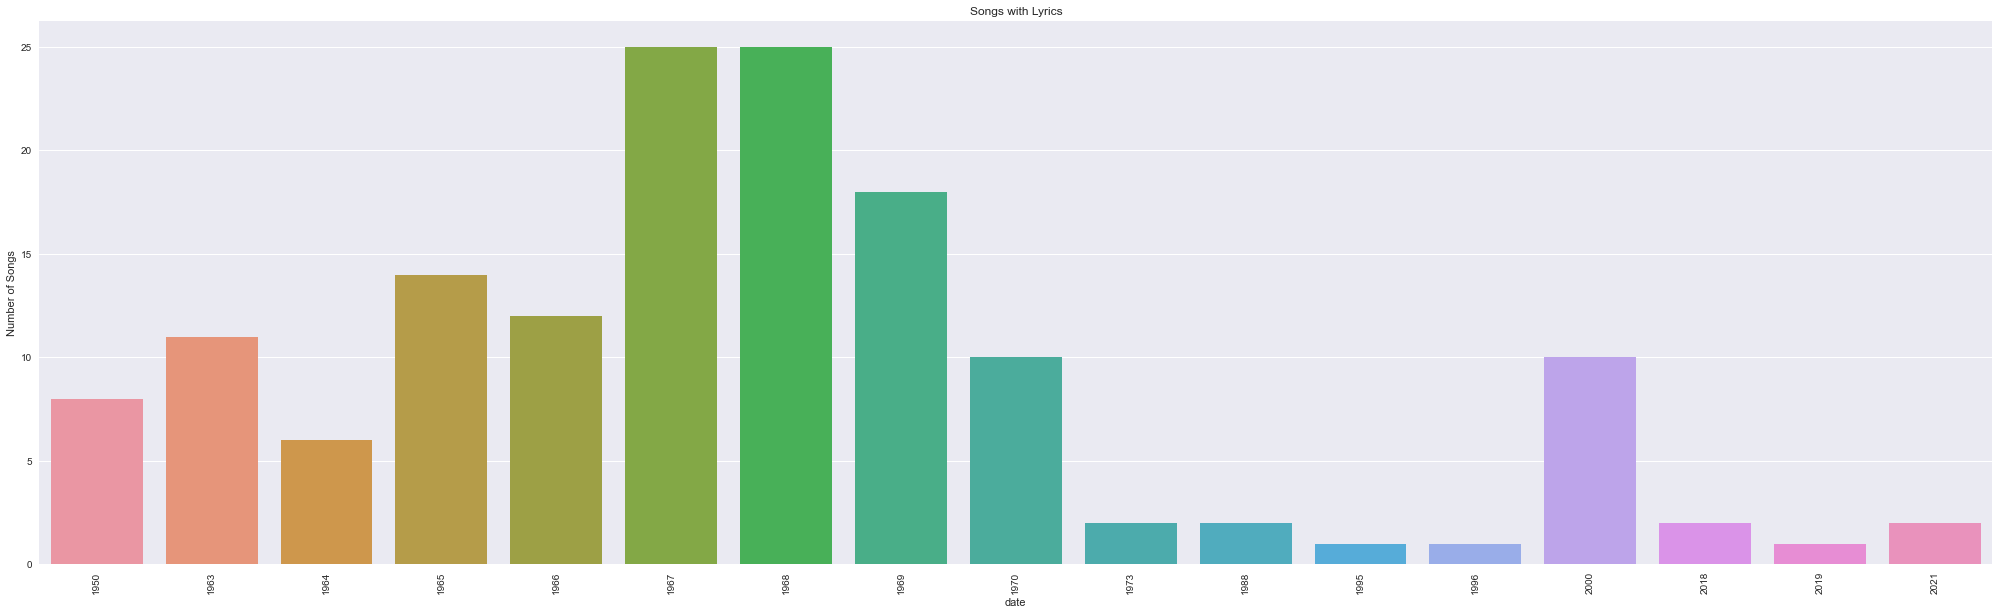

In [26]:
#Gráfica de canciones por año después de la limpieza 
plot_year_counts(songs_with_lyrics_dataset, 'date', 'title', 'Songs with Lyrics')

# Modelado de Datos
## Análisis general de las canciones
#### Extrayendo Verbos, Sustantivos y el Corpus

#### Se utiliza SpaCy para enriquecer el Dataset

In [27]:
prepared_songs_dataset = add_spacy_data(songs_with_lyrics_dataset, 'lyric')

In [28]:
#Mostrando el Dataset
prepared_songs_dataset.head(3)

artist          title decade  date  \
0  The Beatles      Let It Be    70s  1970   
1  The Beatles      Yesterday    60s  1965   
2  The Beatles  Come Together    60s  1969   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           lyric  \
0  when i find myself in times of trouble mother mary comes to me speaking words of wisdom let it be and in my hour of darkness she is standing right in front of me speaking words of wisdom let it be   let it be let it be let it be let it be whisper words of wisdom let it be   and when the brokenhearted people living in the world agree there will be an answer let it be for though they may be parted there is still a chance that they will see there will be an answer let it be   let it be let it be let it be let it be  there will be an answer let it be let it be let it be let it be let it be whisper words of wisdom let it be     let it be let it be let it be  let it be whisper words of wisdom let it be  and when the night is cloudy there is still a light that shines on me shine on 'til tomorrow let it be i wake up to the sound of music mother mary comes to me speaking words of wisdom let it be   let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be whisper words of wisdom let it be   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  yesterday all my troubles seemed so far away now it looks as though they're here to stay oh i believe in yesterday   suddenly  not half the man i used to be there's a shadow hanging over me oh yesterday came suddenly   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday   yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday  yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday   
2                                  shoot me shoot me shoot me shoot me   here come old flattop he come groovin' up slowly he got juju eyeball he one holy roller he got hair down to his knee got to be a joker he just do what he please   shoot me shoot me shoot me shoot me   he wear no shoeshine he got toejam football he got monkey finger he shoot cocacola he say i know you you know me one thing i can 

In [29]:
#Obteniendo cuenta de palabras y palabras únicas 
word_counts = []
unique_word_counts = []
for i in range (0, len(prepared_songs_dataset)):
    word_counts.append(len(prepared_songs_dataset.iloc[i]['lyric'].split()))
    unique_word_counts.append(len(set(prepared_songs_dataset.iloc[i]['lyric'].split())))
prepared_songs_dataset['Word Counts'] = word_counts
prepared_songs_dataset['Unique Word Counts'] = unique_word_counts

In [30]:
#Mostrando Dataset
prepared_songs_dataset.head(3)

artist          title decade  date  \
0  The Beatles      Let It Be    70s  1970   
1  The Beatles      Yesterday    60s  1965   
2  The Beatles  Come Together    60s  1969   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           lyric  \
0  when i find myself in times of trouble mother mary comes to me speaking words of wisdom let it be and in my hour of darkness she is standing right in front of me speaking words of wisdom let it be   let it be let it be let it be let it be whisper words of wisdom let it be   and when the brokenhearted people living in the world agree there will be an answer let it be for though they may be parted there is still a chance that they will see there will be an answer let it be   let it be let it be let it be let it be  there will be an answer let it be let it be let it be let it be let it be whisper words of wisdom let it be     let it be let it be let it be  let it be whisper words of wisdom let it be  and when the night is cloudy there is still a light that shines on me shine on 'til tomorrow let it be i wake up to the sound of music mother mary comes to me speaking words of wisdom let it be   let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be oh there will be an answer let it be let it be let it be let it be  let it be whisper words of wisdom let it be   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  yesterday all my troubles seemed so far away now it looks as though they're here to stay oh i believe in yesterday   suddenly  not half the man i used to be there's a shadow hanging over me oh yesterday came suddenly   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday   yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday   why she had to go i don't know she wouldn't say i said something wrong now i long for yesterday  yesterday love was such an easy game to play now i need a place to hide away oh i believe in yesterday   
2                                  shoot me shoot me shoot me shoot me   here come old flattop he come groovin' up slowly he got juju eyeball he one holy roller he got hair down to his knee got to be a joker he just do what he please   shoot me shoot me shoot me shoot me   he wear no shoeshine he got toejam football he got monkey finger he shoot cocacola he say i know you you know me one thing i can 

In [31]:
#Guardando Dataset en un csv
prepared_songs_dataset.to_csv('prepped_data.csv')

In [32]:
#Mostrando información del primer elemento del dataset
display(prepared_songs_dataset.iloc[0])

artist                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [33]:
#Mostrando los adverbios para la primer canción
display(prepared_songs_dataset.iloc[0]['Adverbs'])

'right still still'

In [34]:
#Leyendo el csv 
#Sirve como Checkpoint
prepared_songs_dataset = pd.read_csv('prepped_data.csv', index_col=0)

## Contando palabras y repeticiones

In [35]:
#Creando dataset con el promedio de palabras y palabras únicas por año
summary_dataset = pd.DataFrame()
years = prepared_songs_dataset['date'].unique().tolist()
for i in range(0, len(years)):
    row = {
        "Year": years[i],
        "Average Words": prepared_songs_dataset['Word Counts'][prepared_songs_dataset['date'] == years[i]].mean(),
        "Unique Words": prepared_songs_dataset['Unique Word Counts'][prepared_songs_dataset['date'] == years[i]].mean()
    }
    summary_dataset = summary_dataset.append(row, ignore_index=True)
summary_dataset["Year"] = summary_dataset['Year'].astype(int)
summary_dataset

Year  Average Words  Unique Words
0   1970     176.100000     59.900000
1   1965     174.500000     65.357143
2   1969     150.055556     52.388889
3   2000     193.600000     68.300000
4   1967     208.520000     81.880000
5   1968     190.400000     73.960000
6   1966     162.916667     65.500000
7   2021     206.000000     61.000000
8   1973     225.000000     79.500000
9   1963     178.181818     46.818182
10  1950     169.875000     67.000000
11  1964     177.500000     56.500000
12  2018     228.000000     76.500000
13  2019      65.000000     31.000000
14  1996     191.000000     62.000000
15  1988     120.500000     51.000000
16  1995     138.000000     48.000000

In [36]:
#Ordenando el dataset
summary_dataset.sort_values('Year', inplace=True) #Se ordenan por año
summary_dataset

Year  Average Words  Unique Words
10  1950     169.875000     67.000000
9   1963     178.181818     46.818182
11  1964     177.500000     56.500000
1   1965     174.500000     65.357143
6   1966     162.916667     65.500000
4   1967     208.520000     81.880000
5   1968     190.400000     73.960000
2   1969     150.055556     52.388889
0   1970     176.100000     59.900000
8   1973     225.000000     79.500000
15  1988     120.500000     51.000000
16  1995     138.000000     48.000000
14  1996     191.000000     62.000000
3   2000     193.600000     68.300000
12  2018     228.000000     76.500000
13  2019      65.000000     31.000000
7   2021     206.000000     61.000000

In [37]:
#Muestra las características que se tienen en el dataset
characteristics = prepared_songs_dataset.groupby('date').count()

In [38]:
characteristics

artist  title  decade  lyric  Verbs  Nouns  Adverbs  Corpus  \
date                                                                
1950       8      8       8      8      8      8        8       8   
1963      11     11      11     11     11     11       11      11   
1964       6      6       6      6      6      6        6       6   
1965      14     14      14     14     14     14       14      14   
1966      12     12      12     12     12     12       12      12   
1967      25     25      25     25     25     25       24      25   
1968      25     25      25     25     25     25       23      25   
1969      18     18      18     18     18     18       16      18   
1970      10     10      10     10     10     10       10      10   
1973       2      2       2      2      2      2        2       2   
1988       2      2       2      2      2      2        2       2   
1995       1      1       1      1      1      1        1       1   
1996       1      1       1      1      1      1        1       1   
2000      10     10      10     10     10     10       10      10   
2018       2      2       2      2      2      2        2       2   
2019       1      1       1      1      1      1        1       1   
2021       2      2       2      2      2      2        2       2   

      Word Counts  Unique Word Counts  
date                                   
1950            8                   8  
1963           11                  11  
1964            6                   6  
1965           14                  14  
1966           12                  12  
1967           25                  25  
1968           25                  25  
1969           18                  18  
1970           10                  10  
1973            2                   2  
1988            2                   2  
1995            1                   1  
1996            1                   1  
2000           10                  10  
2018            2                   2  
2019            1                   1  
2021            2                   2

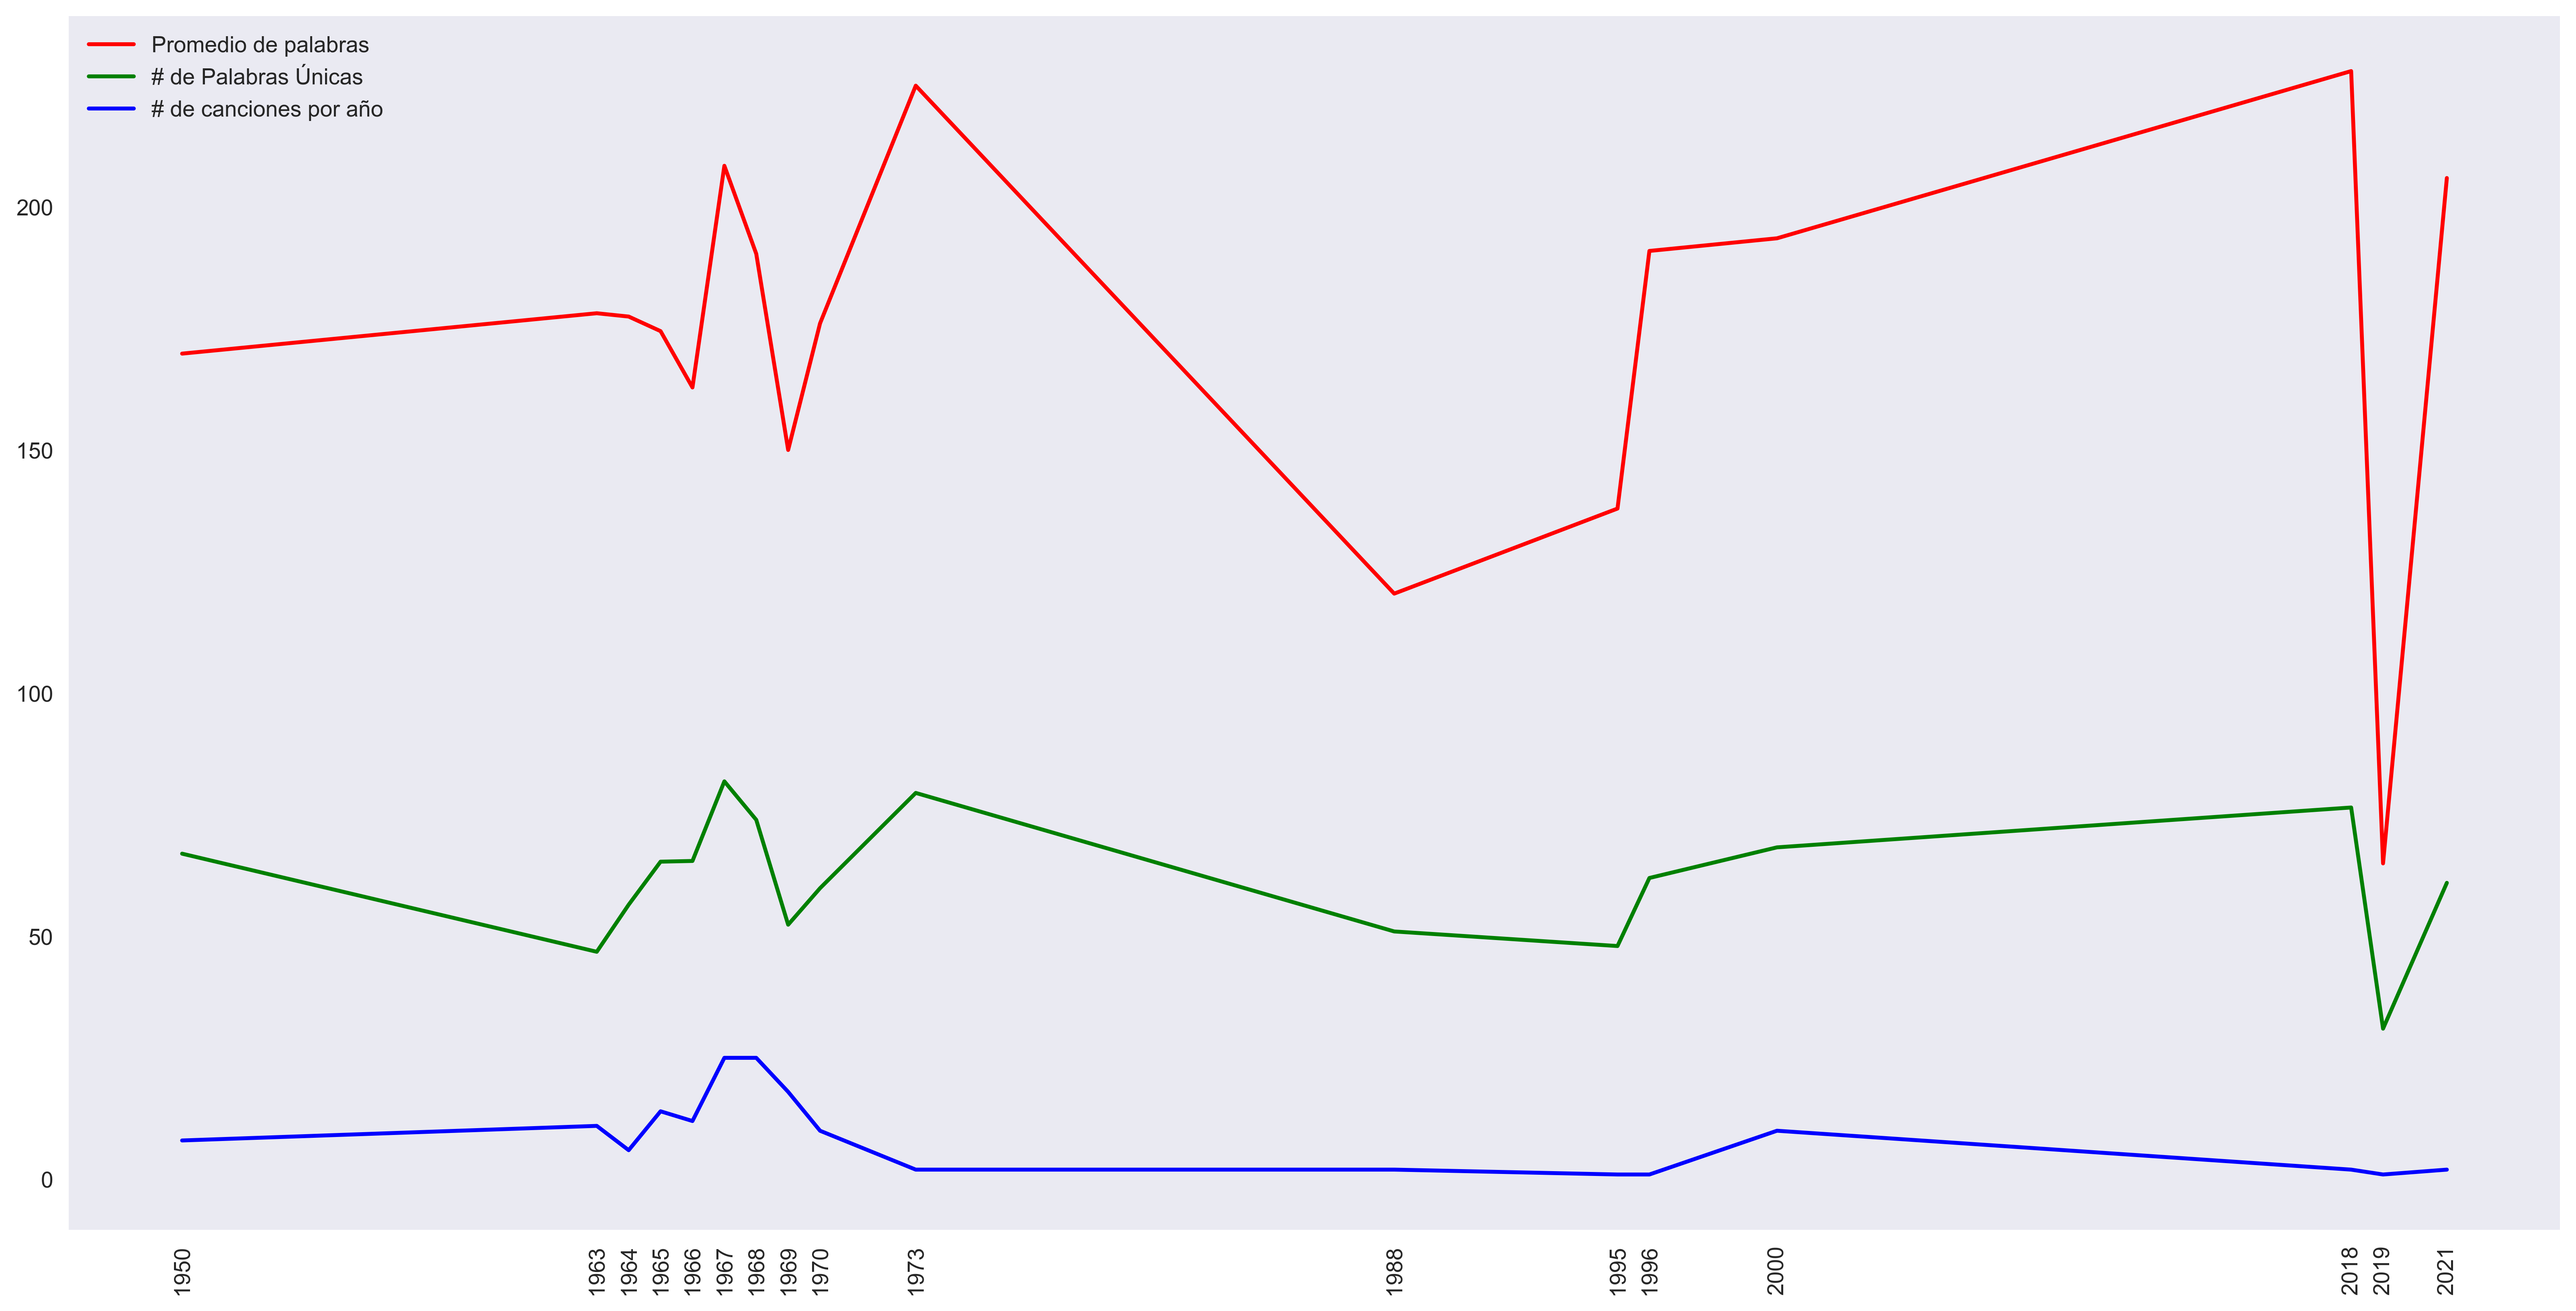

In [39]:
#Graficando la información obtenida
plt.figure(figsize=(20,10), dpi=400)
plt.plot(summary_dataset['Year'], summary_dataset['Average Words'].values, color="red", label="Promedio de palabras")
plt.plot(summary_dataset['Year'], summary_dataset['Unique Words'].values, color="green", label = "# de Palabras Únicas")
plt.plot(characteristics['title'], color="blue", label = "# de canciones por año")
plt.xticks(summary_dataset['Year'], rotation=90)
plt.grid()
plt.legend()
plt.show()

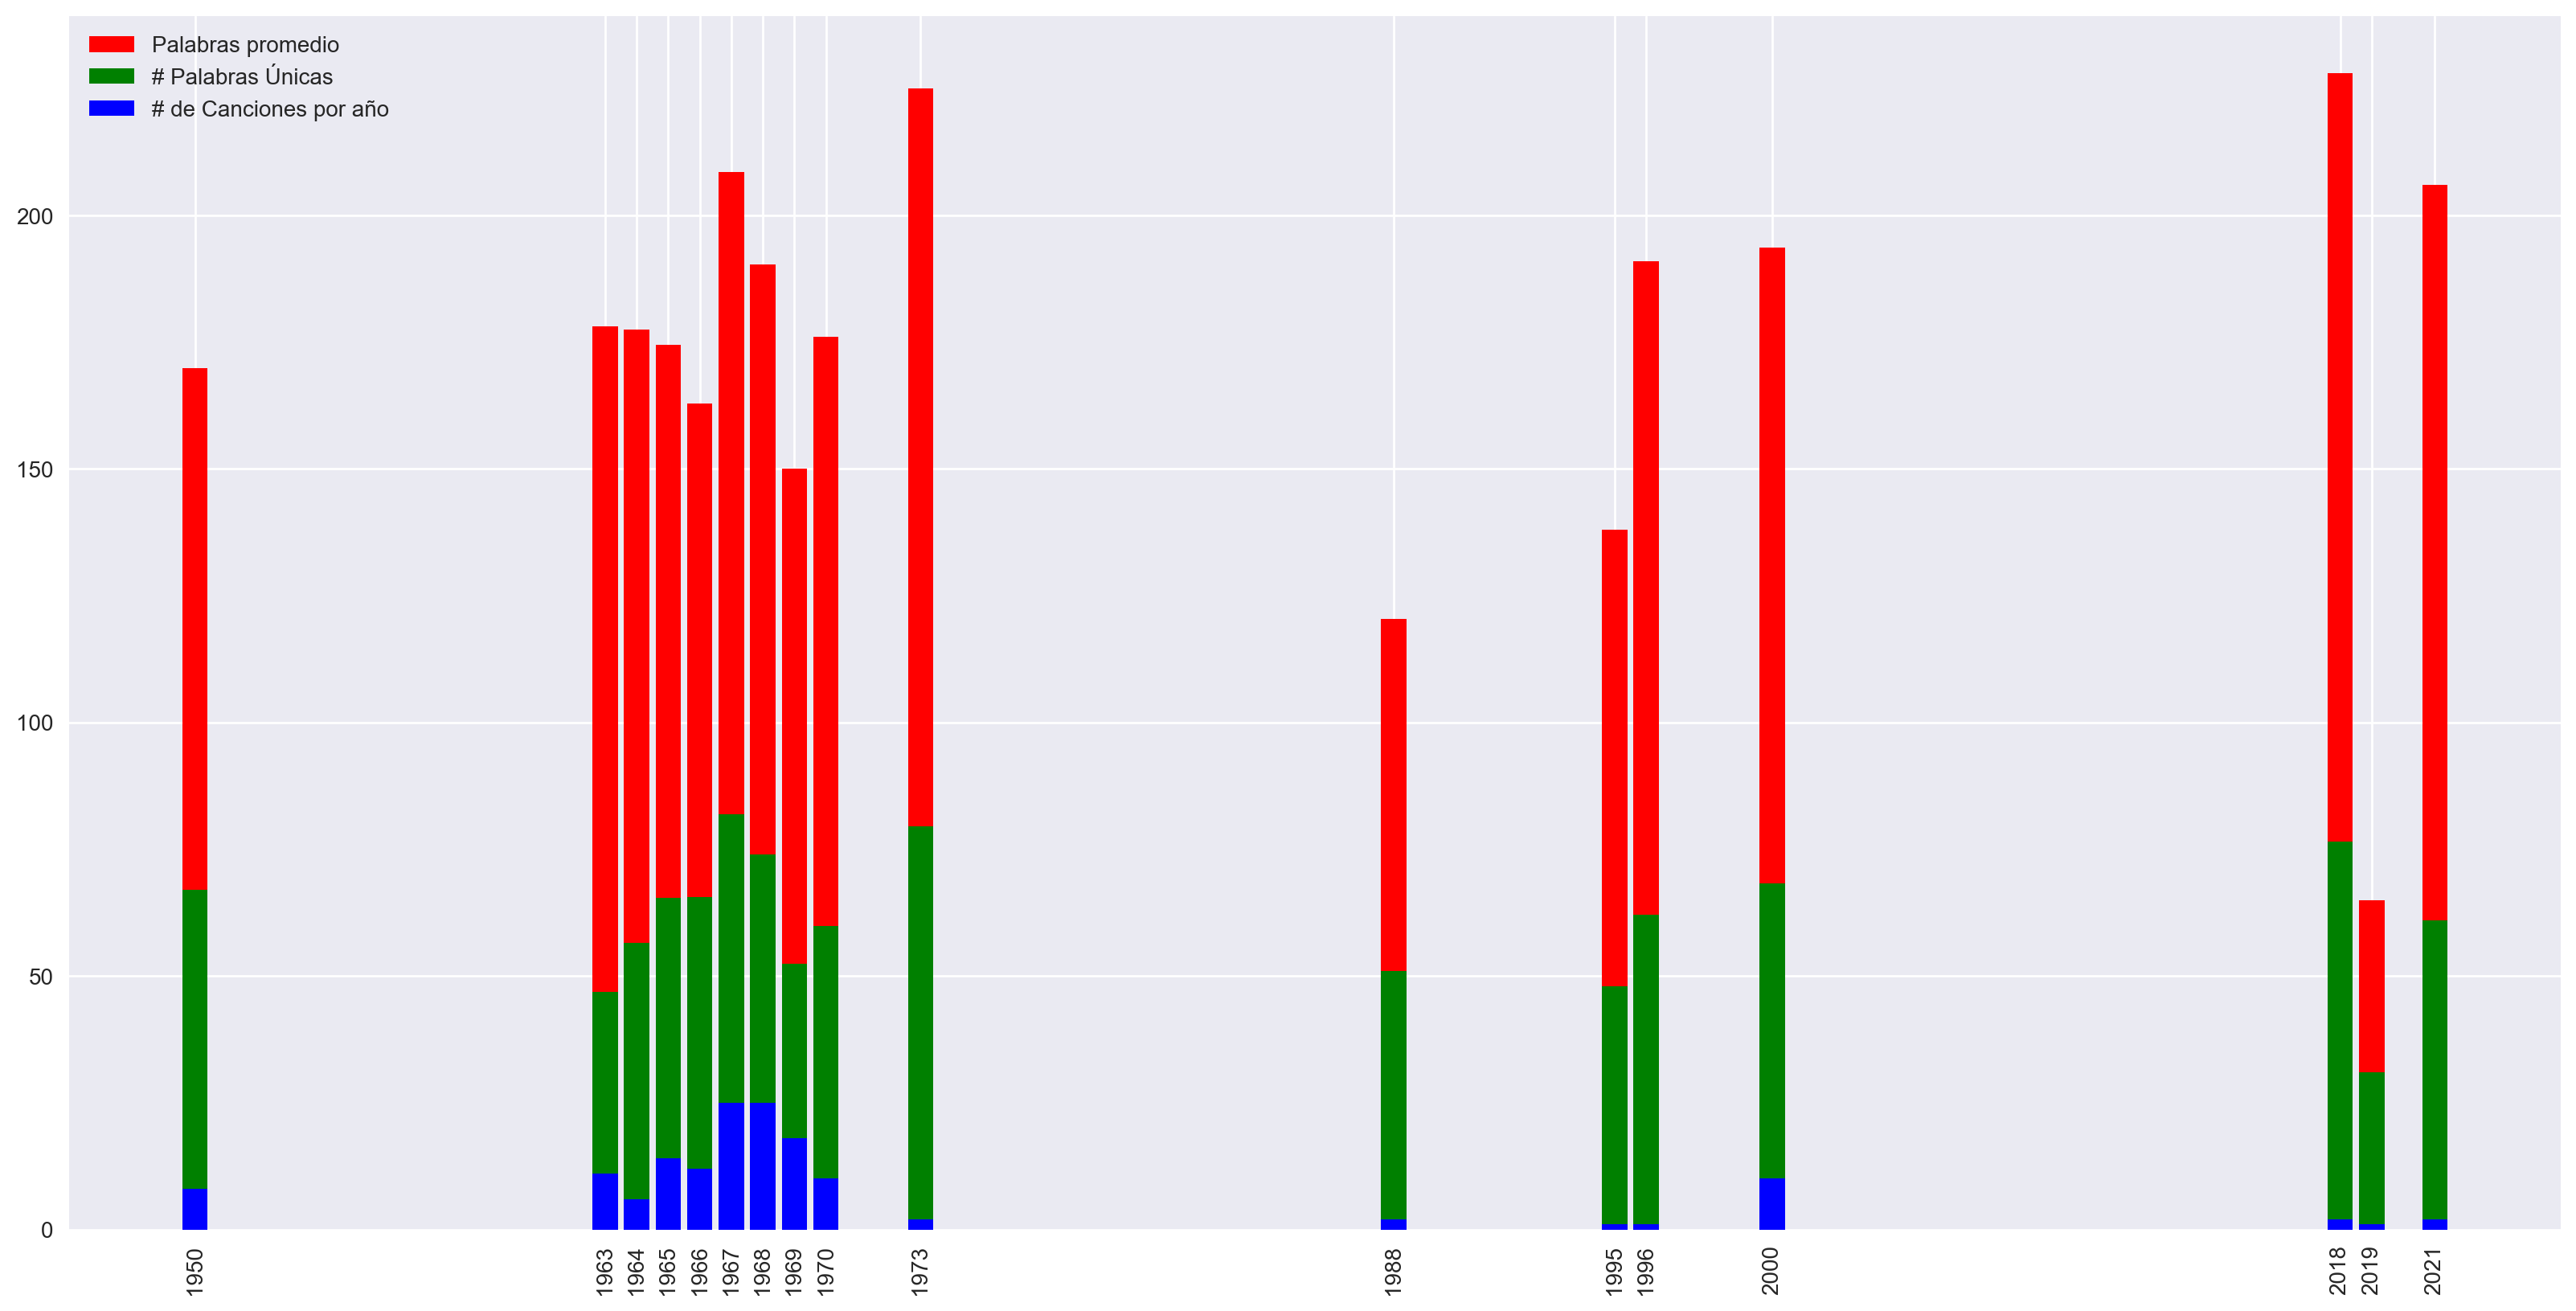

In [40]:
#Graficando la información pero en formato de barras
plt.figure(figsize=(20,10), dpi=200)
plt.bar(summary_dataset['Year'], summary_dataset['Average Words'].values, color="red", label="Palabras promedio")
plt.bar(summary_dataset['Year'], summary_dataset['Unique Words'].values, color="green", label = "# Palabras Únicas")
plt.bar(summary_dataset['Year'], characteristics['title'], color="blue", label = "# de Canciones por año")
plt.xticks(summary_dataset['Year'], rotation=90)
plt.legend()
plt.show()

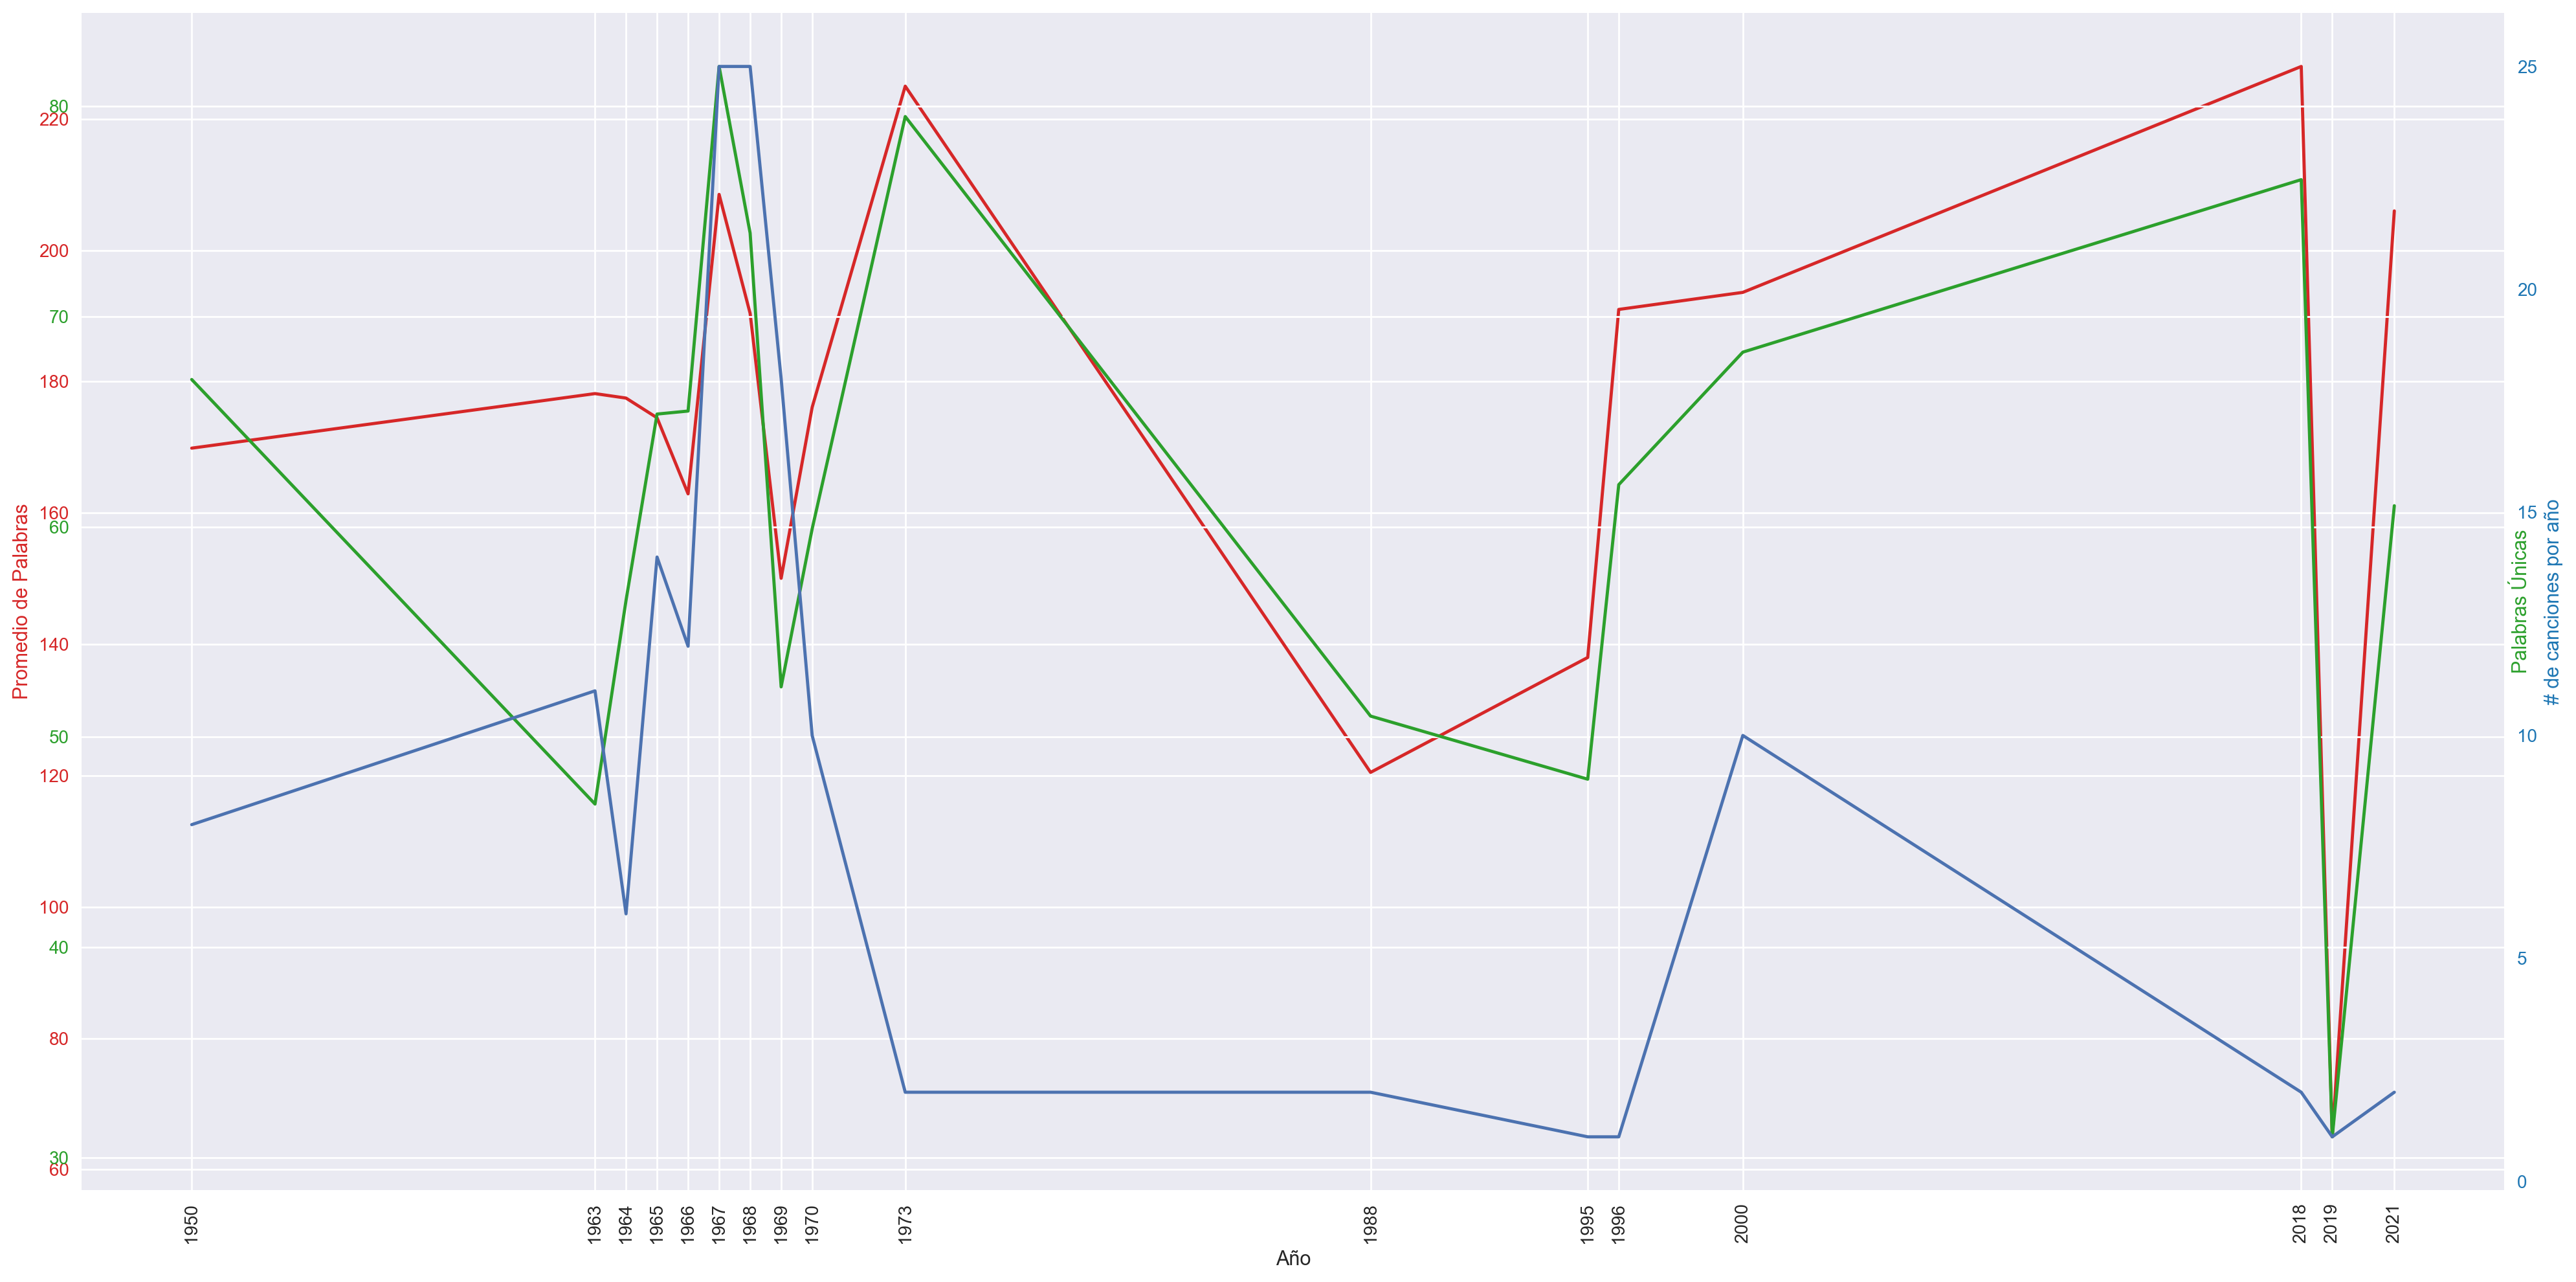

In [41]:
#Superposición de gráficas
fig, ax1 = plt.subplots(figsize=(20,10), dpi=200)

color = 'tab:red'
ax1.set_xlabel('Año')
ax1.set_ylabel('Promedio de Palabras', color=color)
ax1.plot(summary_dataset['Year'], summary_dataset['Average Words'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(summary_dataset['Year'], rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Palabras Únicas', color=color)  # we already handled the x-label with ax1
ax2.plot(summary_dataset['Year'], summary_dataset['Unique Words'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_ylabel("# de canciones por año", color = color)
ax3.plot(characteristics['title'])
ax3.tick_params(axis='y', labelcolor=color)
#plt.plot(characteristics['Rank'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(summary_dataset['Year'], rotation=90)

plt.grid()
plt.show()

In [42]:
#Mostrando el dataset para el año 1969
prepared_songs_dataset[prepared_songs_dataset['date'] == 1969].sort_values(by=['Unique Word Counts'], ascending=False).head(10)

artist                                    title decade  date  \
32   The Beatles                  Maxwell’s Silver Hammer    60s  1969   
110  The Beatles                              Hey Bulldog    60s  1969   
43   The Beatles             You Never Give Me Your Money    60s  1969   
2    The Beatles                            Come Together    60s  1969   
40   The Beatles                         Octopus’s Garden    60s  1969   
65   The Beatles  She Came in Through the Bathroom Window    60s  1969   
149  The Beatles                         All Together Now    60s  1969   
83   The Beatles                         Mean Mr. Mustard    60s  1969   
5    The Beatles                                Something    60s  1969   
77   The Beatles                            Polythene Pam    60s  1969   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      lyric  \
32                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       joan was quizzical studied pataphysical science in the home late nights all alone with a test tube  maxwell edison majoring in medicine calls her on the phone can i take you out t

In [43]:
#Mostrando información para el año 1967
prepared_songs_dataset[prepared_songs_dataset['date'] == 1967].sort_values(by=['Word Counts'], ascending=False).head(10)

artist                               title decade  date  \
9    The Beatles                     I Am the Walrus    60s  1967   
14   The Beatles  With a Little Help from My Friends    60s  1967   
6    The Beatles                   A Day in the Life    60s  1967   
50   The Beatles                      Getting Better    60s  1967   
107  The Beatles           Good Morning Good Morning    60s  1967   
33   The Beatles                          Penny Lane    60s  1967   
37   The Beatles                      Hello, Goodbye    60s  1967   
48   The Beatles                  She’s Leaving Home    60s  1967   
120  The Beatles             Baby, You’re a Rich Man    60s  1967   
13   The Beatles       Lucy in the Sky with Diamonds    60s  1967   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   lyric  \
9    i am he as you are he as you are me and we are all together see how they run like pigs from a gun see how they fly  crying   sitting on a cornflake waiting for the van to come corporation teeshirt stupid bloody tuesday man  been a naughty boy you let your face grow long   i am the eggman they are the eggmen i am the walrus  mister city p'liceman sitting pretty little p'licemen in a row see how they fly like lucy in the sky see how they run  crying  crying  crying  crying   yellowmatter custard dripping from a dead dog's eye crab a locker fishwife pornographic priestess boy  been a naughty girl you let your knickers down  i am the eggman they are the egg men i am the walrus  sitting in an english garden waiting for the sun if the sun don't come you get a tan from standing in the english rain   i am the egg man now good sir what are you they are the egg men a poor man made tame to fortune's blows i am the walrus    expert textpert choking smokers don't you think the joker laughs at you ho ho ho hee hee hee ha ha ha see how they smile like pigs in a sty see how they snied  crying   semolina pilchard climbing up the eiffel tower elementary penguin singing hare krishna man you should have seen them kicking edgar allan poe  i am the eggman they are the eggmen i am the walrus  stick it up your jumper everybody's got one everybody's got one villain take my purse if ever thou wilt thrive bury my body and give the letters which thou findst about me to edmund earl of gloucester seek him out upon the english party oh untime

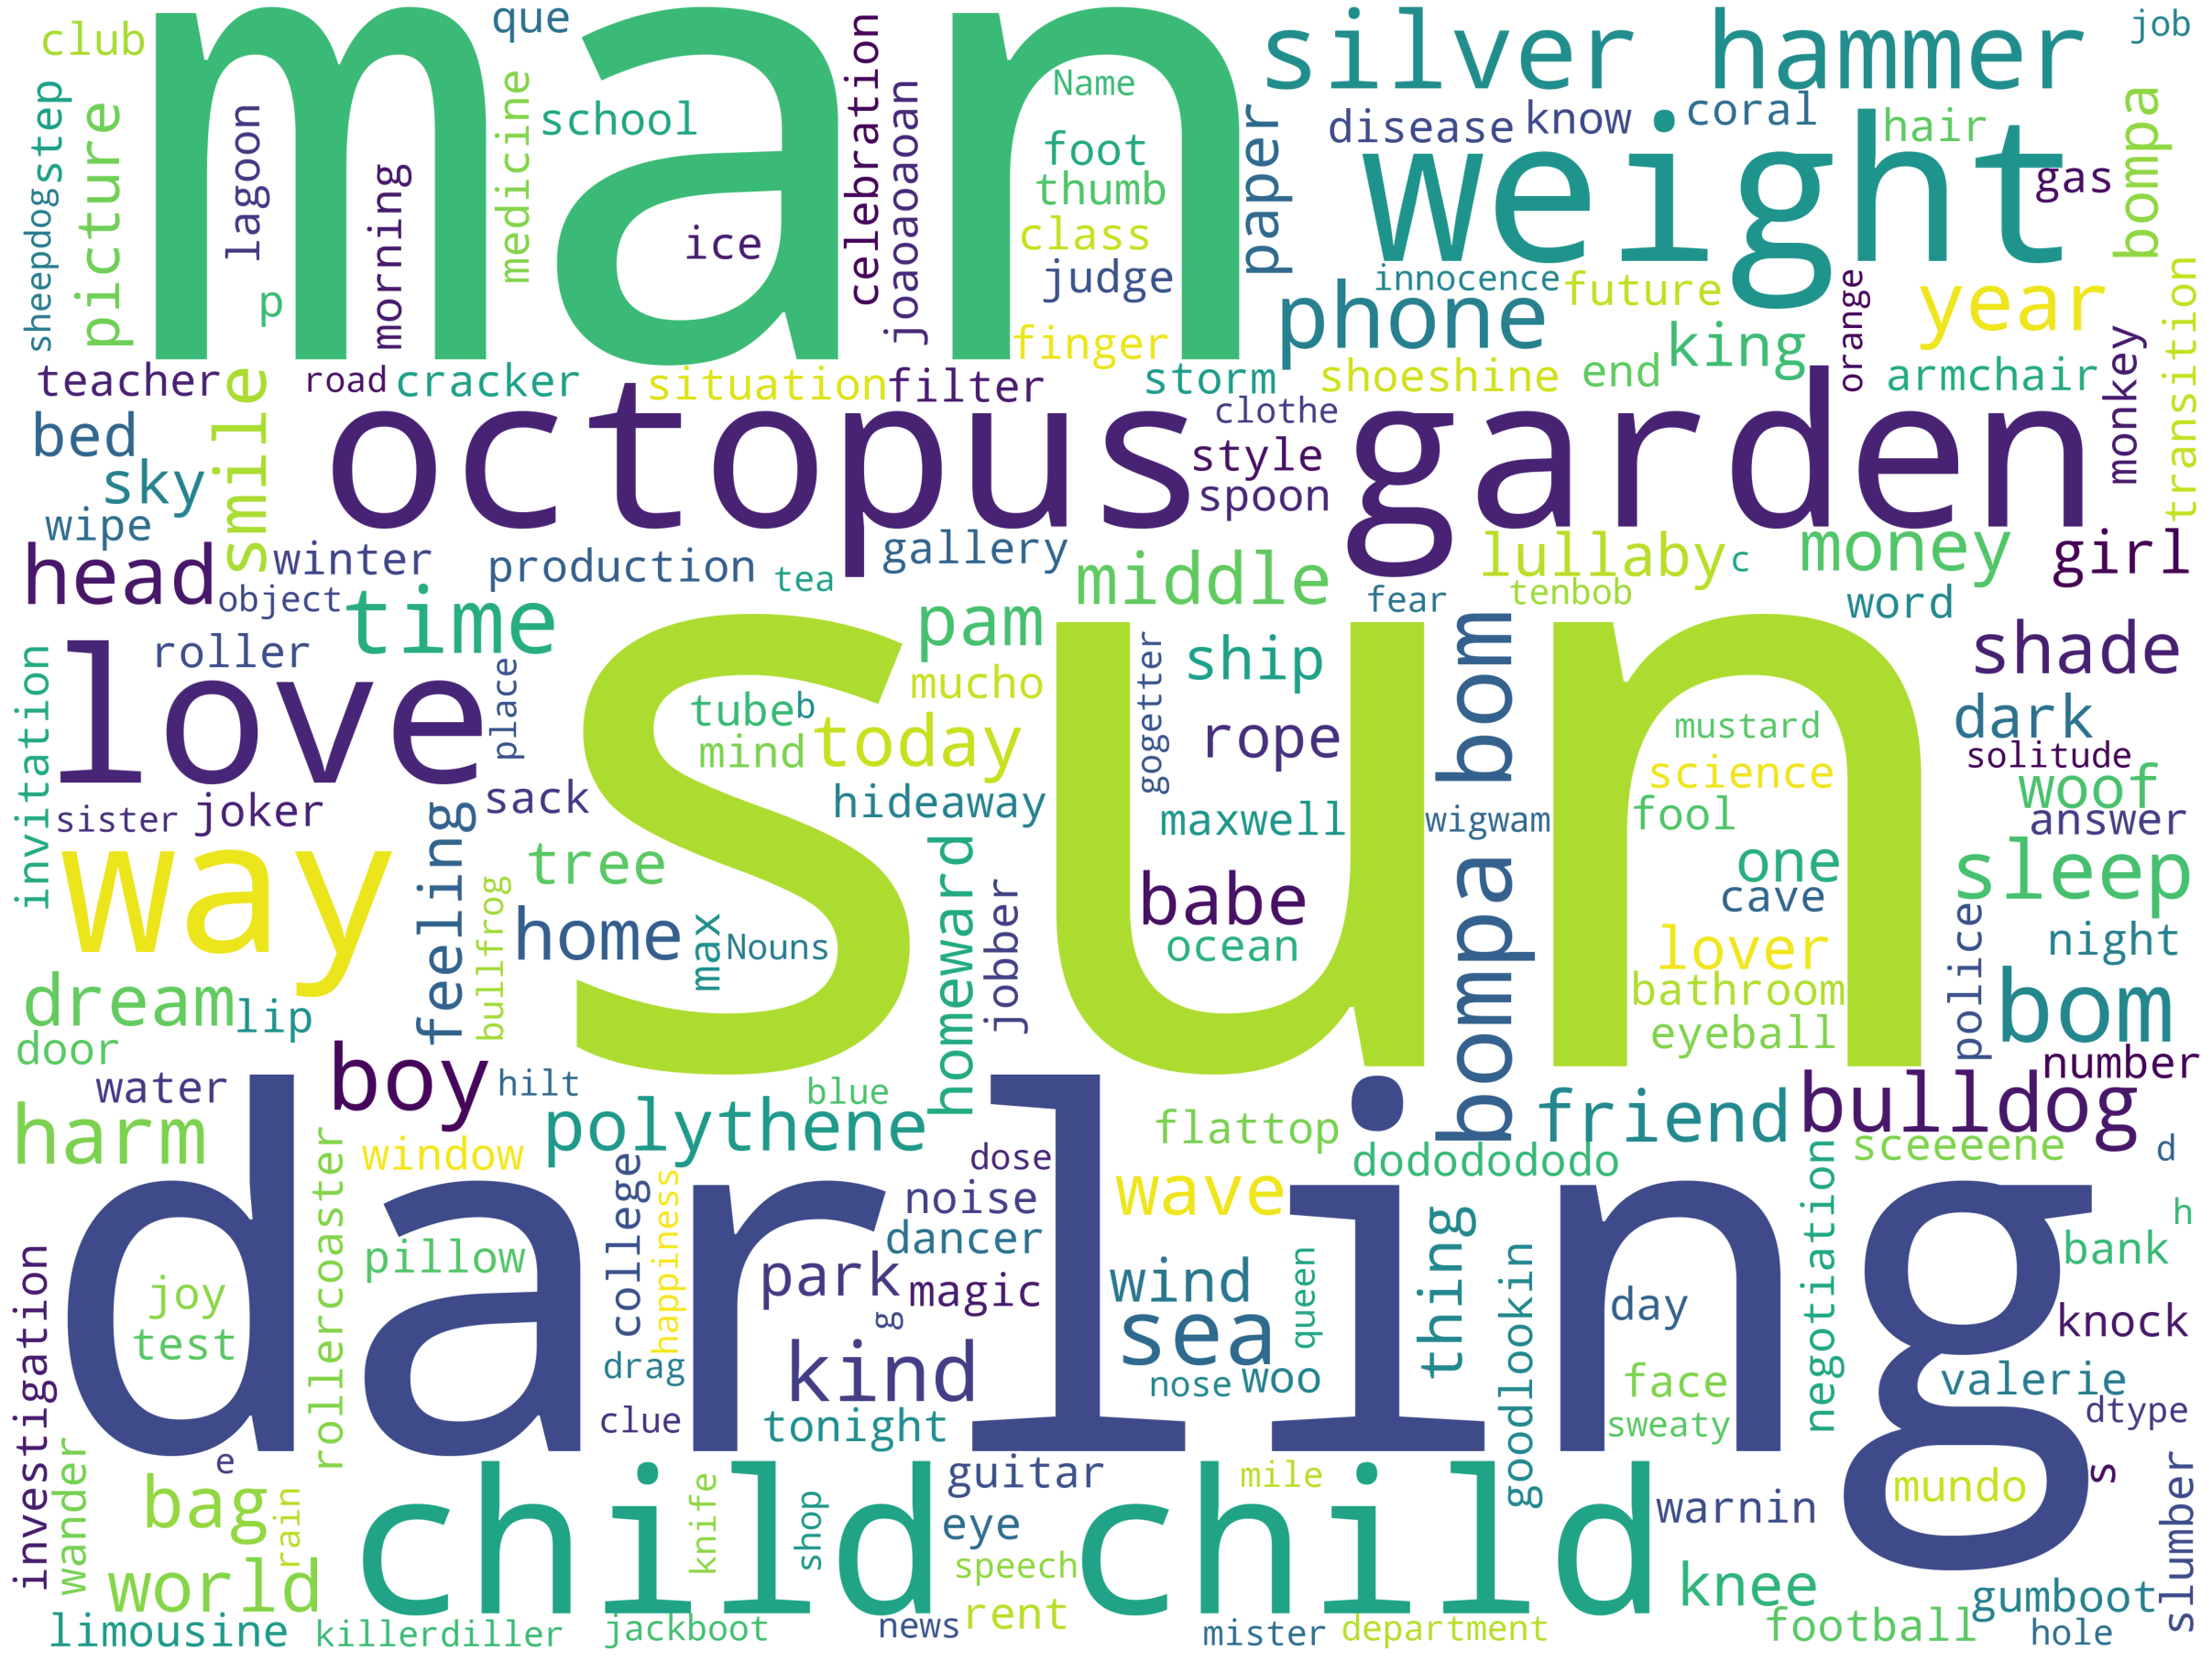

In [44]:
#Generando nube de palabras con los sustantivos de 1969
wordcloud(str(prepared_songs_dataset['Nouns'][prepared_songs_dataset['date'] == 1969]), 250)

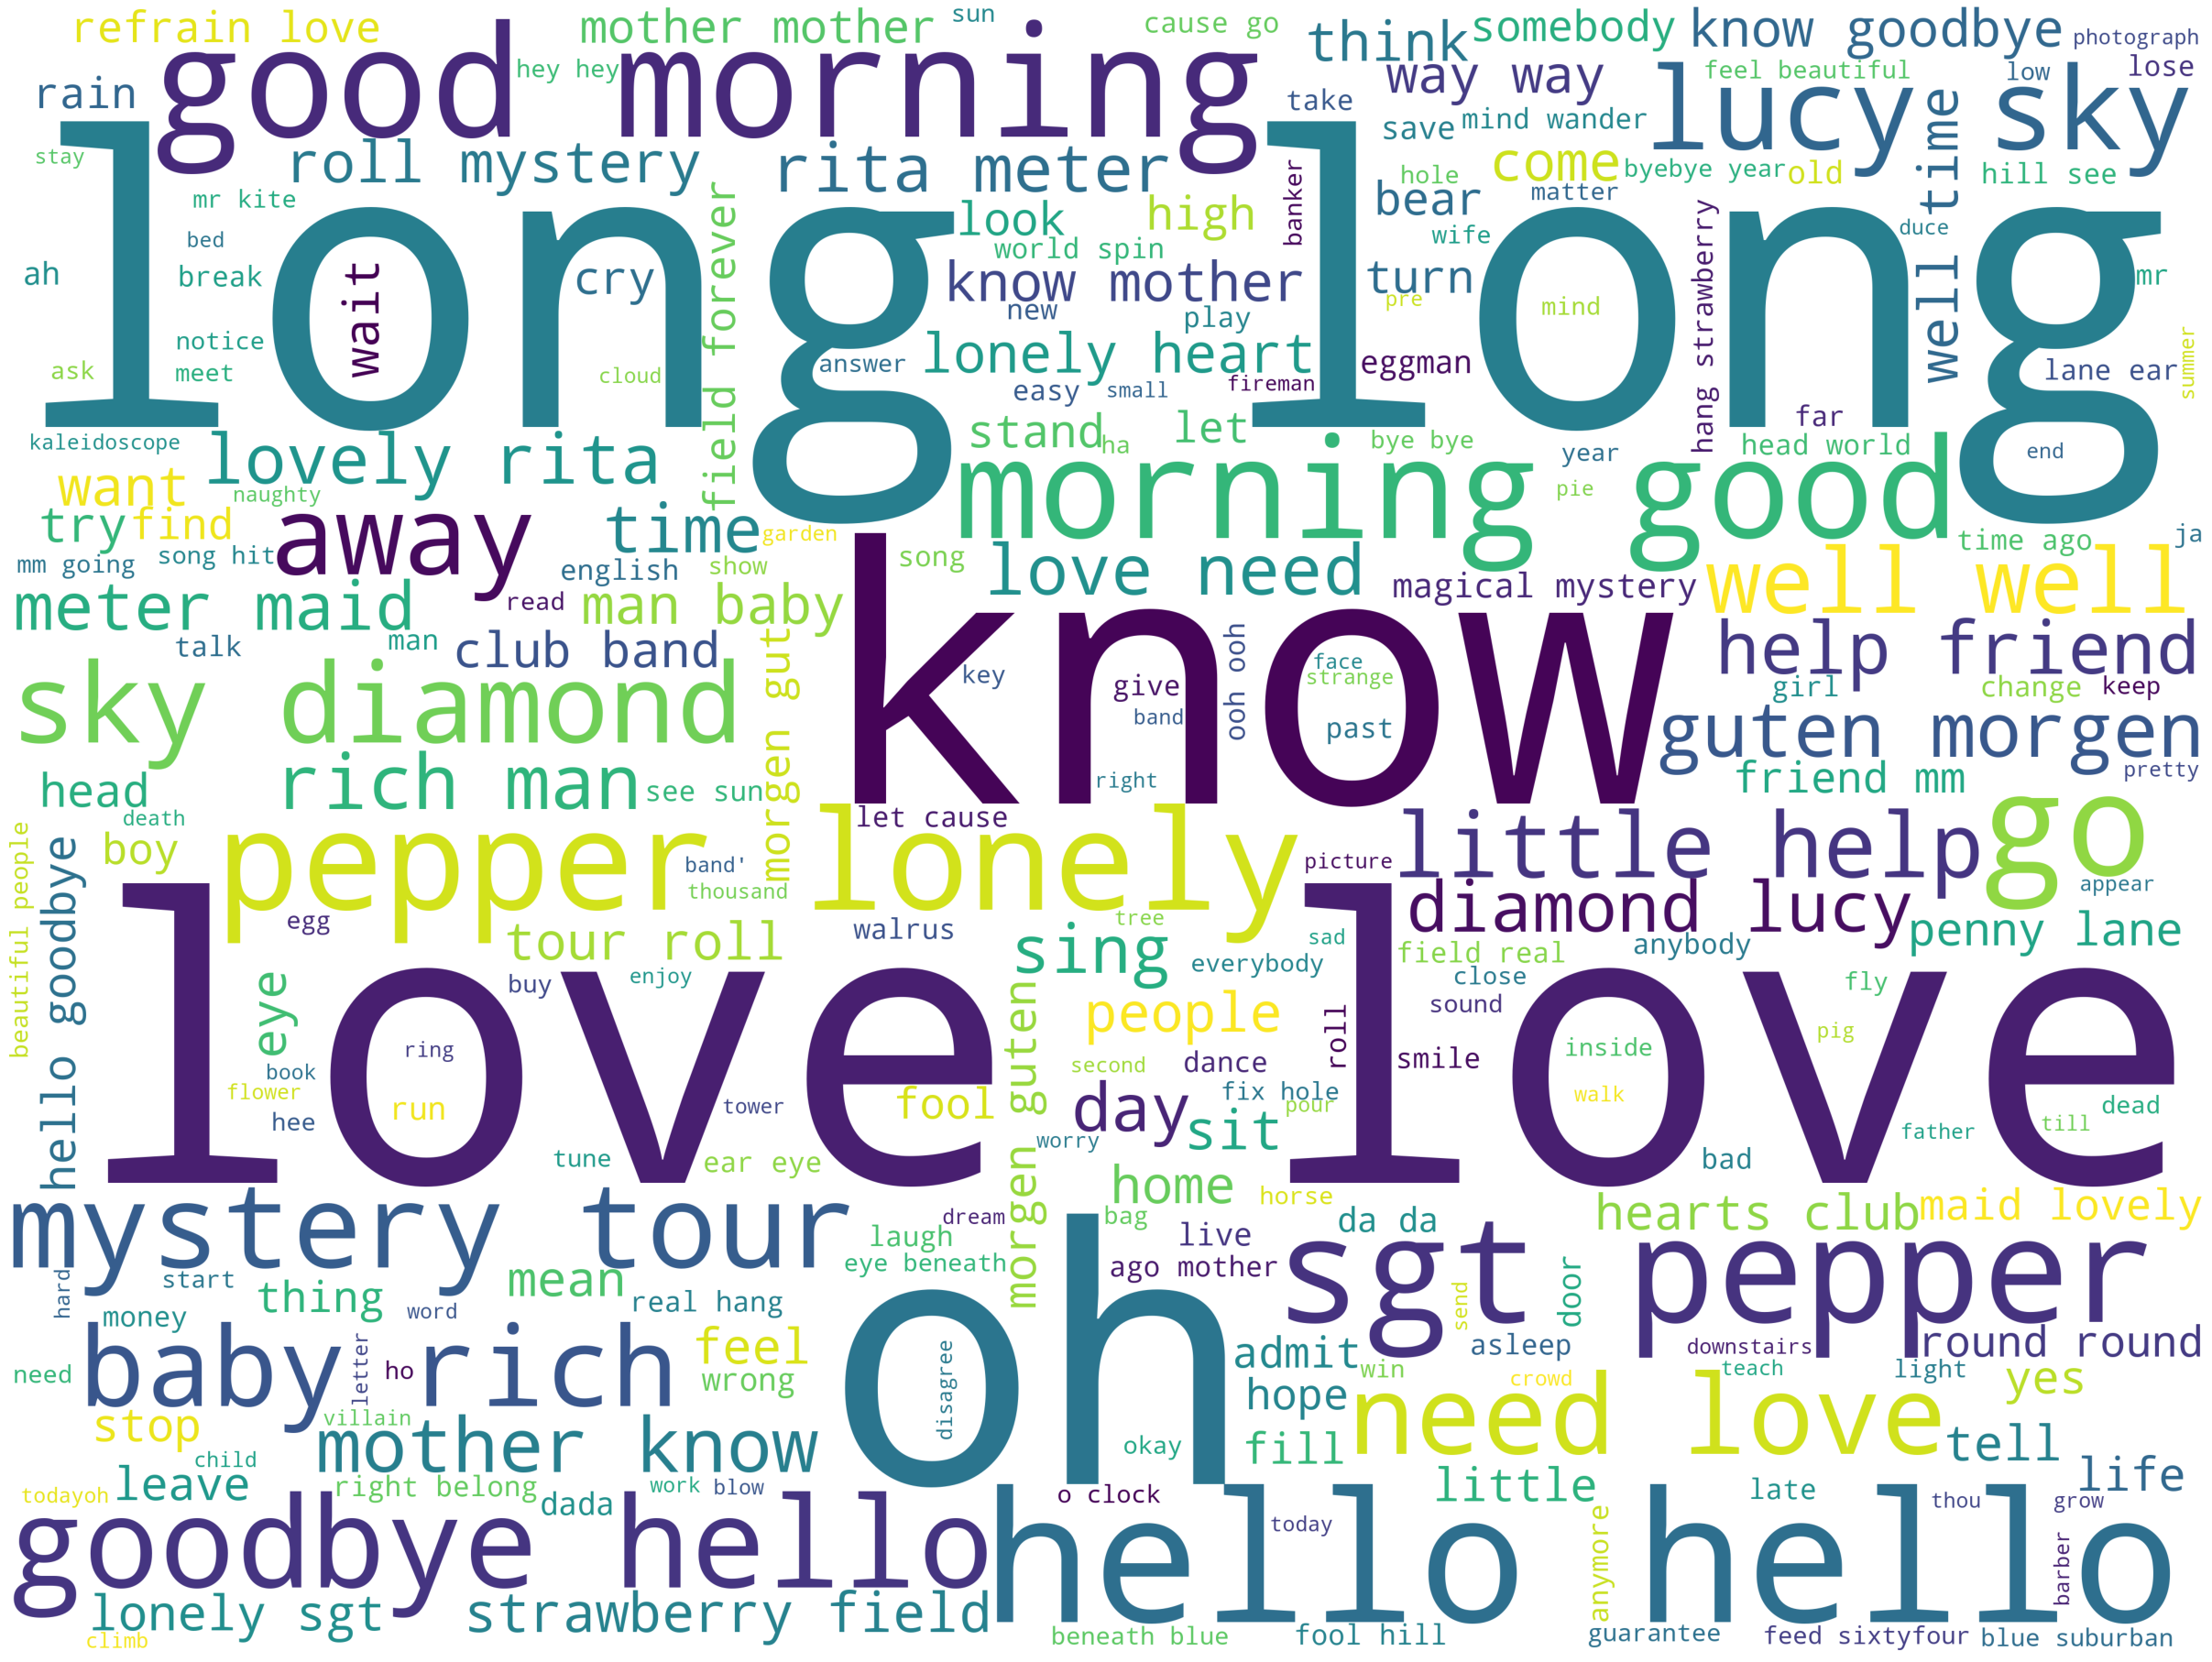

In [45]:
#Generando nube de palabras con los sustantivos de 1967
wordcloud(str(prepared_songs_dataset['Corpus'][prepared_songs_dataset['date'] == 1967].tolist()),250)

## Calculando frecuencia de términos

In [46]:
#Obteniendo las palabras más comunes por año tomando en cuenta el corpus
word_frequencies = pd.DataFrame()
for i in range (0, len(years)):
    year_corpus = str(prepared_songs_dataset['Corpus'][prepared_songs_dataset['date'] == years[i]].tolist())
    tokens = year_corpus.split(" ")
    counts = Counter(tokens)
    word_frequencies = word_frequencies.append({
        "Year": years[i],
        "Most Common Words": counts.most_common(n=100)
    }, ignore_index=True)
word_frequencies['Year'] = word_frequencies['Year'].astype(int)

In [47]:
#Ordenando el dataset con las frecuencias por año
word_frequencies.sort_values('Year', inplace=True)
#Se muestran los tres primeros elementos
word_frequencies.head(3)

Year  \
10  1950   
9   1963   
11  1964   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Most Common Words  
10  [(know, 18), (fallin, 12), (love, 11), (look, 11), (belong, 9), (get, 9), (keep, 9), (go, 8), (think, 7), (mind, 7), (day, 7), (lose, 7), (loser, 7), (oh, 6), (sleep, 6), (time, 6), (yes, 6), (callin, 6), (change, 6), (rain, 6), (girl, 5), (tired, 5), (away, 5), (tomorrow, 5), (follow, 5), (leave, 4), (home, 4), (loretta, 4), (come, 4), (guitar, 4), (little, 4), (peace, 4), (yawn, 4), (float, 4), (stream, 4), (find, 4), (world, 4), (hear, 4), (hey, 4), (hide, 4), (meet, 4), (like, 4), (sun, 4), (jojo, 3), (head, 3), (dream, 3), (wake, 3), (face, 3), (win, 3), (way, 3), (different, 3), (tell, 3), (friend, 3), (end, 3), (appear, 3), (near, 3), (man, 2), (wait, 2), (wear, 2), (wonder, 2), (put, 2), (joke, 2), (harm, 2), (stop, 2), (brain, 2), (week, 2), (insane, 2), (feeling, 2), (monsieur, 2), (early, 2), (morning, 2), (lift, 2), (middle, 2), (stay, 2), (bed, 2), (shake, 2), (need, 2), (spoil, 2), (mile, 2), (break, 2), (eye, 2), (window, 2), (take, 2), (stare, 2), (laugh, 2), (see, 2), (clown, 2), (forget, 2), (place, 2), (want, 2), (treat, 2), (right, 2), (nasty, 2), (habit, 2), (disappear, 2), (overnight, 2), (ohohoh, 2), (fall, 2), (['jojo, 1), (loner, 1)]  
9     [(love, 69), (come, 49), (know, 30), (hold, 27), (baby, 27), (oh, 25), (twist, 18), (get, 18), (girl, 18), (shake, 16), (want, 16), (la, 16), (whoa, 15), (true, 12), (like, 10), (hear, 10), (da, 10), (see, 8), (work, 8), (little, 8), (close, 8), (let, 8), (send, 8), (way, 7), (heart, 7), (home, 7), (word, 7), (anna, 7), (dance, 6), (long, 6), (shout, 6), (tell, 6), (loving, 6), (kiss, 5), (remember, 5), (write, 5), (look, 4), (go, 4), (night, 4), (fine, 4), (till, 4), (ooh, 4), (secret, 4), (set, 4), (free, 4), (leave, 4), (til, 4), (ps, 4), (cause, 4), (cheat, 4), (fall, 3), (tight, 3), (stand, 3), (ring, 3), (miss, 3), (away, 3), (everyday, 3), (need, 3), (listen, 3), (promise, 3), (whisper, 3), (ear, 3), (break, 3), (letter, 3), (day, 3), (sha, 3), (pre, 3), (uh, 3), (standing, 2), (woah, 2), (boom, 2), (cross, 2), (room, 2), (hand, 2), (guitar, 2), (good, 2), (going, 2), (music, 2), (wonderful, 2), (rose, 2), (sweet, 2), (fragrant, 2), (meadow, 2), (dawn, 2), (dew, 2), (singe, 2), (love',, 2), (eye, 2), (tomorrow, 2), (darling, 2), (say, 2), (try, 2), (life, 2), (search, 2), (sad, 2), (suppose, 2), (thing, 2), (treasure, 2), (forever, 2), (refrain, 2)]  
11                         [(love, 52), (day, 17), (know, 12), (like, 11), (hold, 11), (cause, 10), (home, 9), (week, 9), (oh, 8), (thing, 7), (feel, 7), (see, 7), (die, 7), (babe, 7), (night, 6), (need, 6), (girl, 6), (hey, 6), (hard, 5), (get, 5), (hand, 5), (work, 4), (find, 4), (alright, 4), (tight, 4), (hope, 4), (be, 4), (walk, 4), (nearly, 4), (dog, 3), (sleep, 3), (log, 3), (guitar, 3), (kiss, 3

In [48]:
#Mostrando dataset ordenado por año
prepared_songs_dataset.sort_values('date', inplace=True)
#Se muestran los primeros tres elementos
prepared_songs_dataset.head(3)

artist                    title decade  date  \
55   The Beatles             I’m So Tired    50s  1950   
147  The Beatles              I’m a Loser    50s  1950   
112  The Beatles  I’m Looking Through You    50s  1950   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       lyric  \
55   so tired i haven't slept a wink  so tired my mind is on the blink i wonder should i get up and fix myself a drink no no no    so tired i don't know what to do  so tired my mind is set on you i wonder should i call you but i know what you would do   you'd say  putting you on but it's no joke it's doing me harm you know i can't sleep i can't stop my brain you know it's three weeks  going insane you know i'd give you everything  got for a little peace of mind    so tired  feeling so upset although  so tired i'll have another cigarette and curse sir walter raleigh he was such a stupid git   you'd say  putting you on but it's no joke it's doing me harm you know i can't sleep i can't stop my brain you know it's three weeks  going insane you know i'd give you everything  got for a little peace of mind i'd give you everything  got for a little peace of mind i'd give you everything  got for a little peace of mind  monsieur monsieur monsieur how about another one   
147                                                                                                                                                             a loser  a loser and  not what i appear to be   of all the love i have won or have lost there is one love i should never have crossed she was a girl in a million my friend i should have known she would win in the end    a loser and i lost someone who's near to me  a loser and  not what i appear to be  although i laugh and i act like a clown beneath this mask i am wearing a frown my tears are falling like rain from the sky is it for her or myself that i cry    a loser and i lost someone who's near to me  a loser and  not what i appear to be harmonica and guitar s   what have i done to deserve such a fate i realise i have left it too late and so it's true pride comes before a fall  telling you so that you won't lose all    a loser and i lost someone who's near to me  a loser and  not what i appear to be   
112                  looking through you where did you go i thought i knew you what did i know you don't look different but you have changed  looking through you you're not the same   your lips are moving i cannot hear your voice is soothing but the words aren't clear you don't sound different  learned the game  looking through you you're not the same   why tell me why did you not treat me right love has a nasty habit of disappearing overnight   you're thinking of me the same old way you were above me but not today the only difference is you're down there  looking through you and you're nowhere   why tell me why did you not treat me right love has a nasty habit of disappearing overnight   looking through you where did you go i thought i knew you what did i know you don't look different but you have changed  looking through you you're not

In [49]:
#Obteniendo las frecuencias para cada parte del discurso
#Adverbios
adverb_frequencies = map_popular_terms(prepared_songs_dataset, "Adverbs", "date")
#Sustantivos
noun_frequencies = map_popular_terms(prepared_songs_dataset, "Nouns", "date")
#Verbos
verb_frequencies = map_popular_terms(prepared_songs_dataset, "Verbs", "date")
#Corpus
word_frequencies = map_popular_terms(prepared_songs_dataset, "Corpus", "date")

In [50]:
#Mostrando frecuencia de adverbios por año
adverb_frequencies

Year  \
0   1950   
1   1963   
2   1964   
3   1965   
4   1966   
5   1967   
6   1968   
7   1969   
8   1970   
9   1973   
10  1988   
11  1995   
12  1996   
13  2000   
14  2018   
15  2019   
16  2021   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Most Common Terms  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [(back, 36), (once, 9), (so, 7), (just, 5), (again, 5), (away, 5), (never, 4), (only, 3), (so',, 2), (there, 2), (still, 2), (everywhere, 2), (['so, 1), (insane, 1), (insane',, 1), ('never, 1), (too, 1), (late, 1), ('overnight, 1), (down, 1), (nowhere, 1), (overnight',, 1), ('now, 1), (now, 1), ('just, 1), (quite, 1), (again',, 1), ('early, 1), (backwards, 1), (early, 1), (only',, 1), ('here, 1), (even, 1), (round, 1), (away',, 1), ('back, 1), (home, 1), (back'], 1)]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [(now, 20), (really, 17), (never, 13), (so, 12), (always, 8), (on, 6), (then, 5), (just, 5), (there, 5), (well, 5), (all, 5), ('never, 4), (at, 4), (close, 4), (away, 3), ('always, 3), (too, 3), (long, 3), (everyday, 2), (ever, 2), (just',, 2), (much, 2), (together, 2), (forever, 2), (home, 2), (around, 2), (here, 2), (['always, 1), (everyday',, 1), (so',, 1), (ever',, 1), ('so, 1), (still, 1), (more, 1), (again, 1), (again',, 1), ('just, 1), (there',, 1), (all',, 1), (badly, 1), (madly, 1), (tig

In [51]:
#Mostrando frecuencia de sustantivos por año
noun_frequencies

Year  \
0   1950   
1   1963   
2   1964   
3   1965   
4   1966   
5   1967   
6   1968   
7   1969   
8   1970   
9   1973   
10  1988   
11  1995   
12  1996   
13  2000   
14  2018   
15  2019   
16  2021   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Most Common Terms  
0                                                                                                                                         [(love, 10), (day, 7), (loser, 6), (time, 6), (mind, 5), (girl, 5), (tomorrow, 5), (peace, 4), (sun, 4), (world, 4), (friend, 3), (end, 3), (way, 3), (stream, 3), (home, 3), (loretta, 3), (joke, 2), (harm, 2), (brain, 2), (week, 2), (feeling, 2), (habit, 2), (place, 2), (face, 2), (head, 2), (middle, 2), (dream, 2), (stay, 2), (bed, 2), (need, 2), (mile, 2), (eye, 2), (window, 2), (guitar, 2), (['wink, 1), (blink, 1), (drink, 1), (cigarette, 1), (git, 1), (mind',, 1), ('loser, 1), (clown, 1), (mask, 1), (frown, 1), (tear, 1), (rain, 1), (sky, 1), (fate, 1), (pride, 1), (fall, 1), (loser',, 1), ('lip, 1), (voice, 1), (word, 1), (game, 1), (today, 1), (difference, 1), (baby',, 1), ('day, 1), (sun',, 1), ("face, 1), (tonight, 1), (like, 1), (thing, 1), (sight, 1), (dadan'dada'n'da, 1), (fallin",, 1), ('morning, 1), (speed, 1), (ceiling, 1), (morning, 1), (stream',, 1), ('head, 1), (hand, 1), (wall, 1), (twofoot, 1), (people, 1), (state, 1), (love',, 1), ('man, 1), (loner, 1), (jo, 1), (woman, 1), (man, 1), (hoo, 1), (mommy, 1), (highheel, 1), (shoe, 1), (sweater, 1), (loretta'], 1)]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [(baby, 26), (love, 21), (girl, 17), (hold, 14), (twist, 8), (heart, 7), (word, 7), (home, 5), (loving, 5), (way, 5), (anna, 5), (night, 4), (love',, 3), (cheat, 3), (ear, 3), (secret, 3), (day, 3), (tomorrow, 2), (darling, 2), ('way, 2), (baby',, 2), (life, 2), (thing, 2), (ring, 2), (letter, 2), (standing, 2), (woah, 2), (boom, 2), (room, 2), (hand, 2), (music, 2), (rose, 2), (meadow, 2), (dawn, 2), (dew, 2), (['eye, 1), (lip, 1), (dream, 1), (eye, 1), (loving',, 1), ('love, 1), ('anna, 1), (anna',, 1), ('secret, 1), (week, 1), ('letter, 1), (ps, 1), (ps',, 1), (compare, 1), (standing',, 1), ('bell, 1), (hill, 1), (bird, 1), (sky, 1), ('hold, 1), (hold',, 1), ('baby, 1), (look, 1), ('night, 1), (rain, 1), (girl'], 1)]  
2                                                                           

In [52]:
#Mostrando frecuencia de verbos por año
verb_frequencies

Year  \
0   1950   
1   1963   
2   1964   
3   1965   
4   1966   
5   1967   
6   1968   
7   1969   
8   1970   
9   1973   
10  1988   
11  1995   
12  1996   
13  2000   
14  2018   
15  2019   
16  2021   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Most Common Terms  
0                                                                                                                                                           [(get, 43), (know, 18), (go, 15), (look, 10), (belong, 9), (keep, 8), (lose, 7), (say, 6), (think, 6), (change, 6), (see, 6), (do, 5), (sleep, 5), (rain, 5), (give, 4), (leave, 4), (come, 4), (hear, 4), (follow, 4), (find, 4), (meet, 4), (float, 4), (have, 3), (win, 3), (be, 3), (tell, 3), (yawn, 3), (wake, 3), (hide, 3), (wonder, 2), (put, 2), (stop, 2), (appear, 2), (laugh, 2), (wear, 2), ('look, 2), (treat, 2), (disappear, 2), (forget, 2), (want, 2), (fallin, 2), (lift, 2), (shake, 2), (spoil, 2), (break, 2), (take, 2), (stare, 2), (wait, 2), (['sleep, 1), (fix, 1), (set, 1), (call, 1), (curse, 1), (get',, 1), ('appear, 1), (cross, 1), (act, 1), (fall, 1), (cry, 1), (deserve, 1), (realise, 1), (appear',, 1), (move, 1), (soothe, 1), (sound, 1), (learn, 1), (change',, 1), (follow',, 1), ('see, 1), (dream, 1), (miss, 1), (keep',, 1), ('wake, 1), (seem, 1), (mind, 1), (run, 1), (lie, 1), (sleep',, 1), ('stand, 1), (turn, 1), (feel, 1), (try, 1), (gather, 1), (clown, 1), (let, 1), (hide',, 1), ('think, 1), (last, 1), (get'], 1)]  
1                                                                      [(love, 45), (come, 37), (know, 29), (get, 17), (want, 16), (do, 15), (shake, 15), (go, 13), (hold, 12), (say, 11), (be, 10), (twist, 10), (hear, 9), (send, 8), (let, 8), (see, 8), (work, 8), (please, 8), (tell, 6), (dance, 6), (shout, 6), (kiss, 5), (remember, 5), (write, 5), (leave, 4), (set, 4), (miss, 3), (break, 3), (listen, 3), (promise, 3), (whisper, 3), (look, 3), (fall, 3), (stand, 3), (need, 3), (matter, 2), (search, 2), (suppose, 2), (give, 2), ('know, 2), (treasure, 2), (keep, 2), (ps, 2), (cross, 2), (singe, 2), (refrain, 2), (try, 2), (['close, 1), (pretend, 1), (hope, 1), (send',, 1), ('love, 1), (do',, 1), ('smile, 1), (touch, 1), (tear, 1), (sit, 1), (cry, 1), (help, 1), (cheat, 1), (come',, 1), ('come, 1), (ask, 1), (go',, 1), (care, 1), (hear',, 1), ('write, 1), (love',, 1), (mean, 1), (see',, 1), ('be, 1), (ring, 1), (wing, 1), (be',, 1), ('like, 1), (seem, 1), (think, 1), (treat, 1), (stay, 1), (spend, 1), (split, 1), (quit, 1), (squeeze, 1), (get',, 1), ('shake, 1), (going, 1), (shake',, 1), ('say, 1), (show, 1), (have, 1), (sound, 1), (complain, 1), (reason, 1), (make, 1), (please'], 1)]  
2                                                                                                                                                                                       

In [53]:
#Mostrando frecuencia de palabras por año
word_frequencies

Year  \
0   1950   
1   1963   
2   1964   
3   1965   
4   1966   
5   1967   
6   1968   
7   1969   
8   1970   
9   1973   
10  1988   
11  1995   
12  1996   
13  2000   
14  2018   
15  2019   
16  2021   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Most Common Terms  
0                 [(know, 18), (fallin, 12), (love, 11), (look, 11), (get, 9), (keep, 9), (belong, 9), (go, 8), (mind, 7), (loser, 7), (lose, 7), (think, 7), (day, 7), (sleep, 6), (rain, 6), (change, 6), (oh, 6), (time, 6), (yes, 6), (callin, 6), (tired, 5), (girl, 5), (tomorrow, 5), (follow, 5), (away, 5), (little, 4), (peace, 4), (like, 4), (guitar, 4), (leave, 4), (come, 4), (hear, 4), (sun, 4), (find, 4), (meet, 4), (world, 4), (yawn, 4), (float, 4), (stream, 4), (hey, 4), (hide, 4), (home, 4), (loretta, 4), (appear, 3), (win, 3), (friend, 3), (end, 3), (near, 3), (tell, 3), (different, 3), (way, 3), (face, 3), (dream, 3), (head, 3), (wake, 3), (jojo, 3), (wonder, 2), (put, 2), (joke, 2), (harm, 2), (stop, 2), (brain, 2), (week, 2), (insane, 2), (feeling, 2), (monsieur, 2), (laugh, 2), (clown, 2), (wear, 2), (fall, 2), (treat, 2), (right, 2), (nasty, 2), (habit, 2), (disappear, 2), (overnight, 2), (ohohoh, 2), (forget, 2), (place, 2), (want, 2), (see, 2), (early, 2), (morning, 2), (lift, 2), (middle, 2), (stay, 2), (bed, 2), (shake, 2), (need, 2), (spoil, 2), (mile, 2), (break, 2), (eye, 2), (window, 2), (take, 2), (stare, 2), (wait, 2), (man, 2), (['tired, 1), (wink, 1)]  
1               [(love, 69), (come, 49), (know, 30), (baby, 27), (hold, 27), (oh, 25), (girl, 18), (get, 18), (twist, 18), (la, 16), (want, 16), (shake, 16), (whoa, 15), (true, 12), (like, 10), (hear, 10), (da, 10), (send, 8), (close, 8), (let, 8), (see, 8), (work, 8), (little, 8), (home, 7), (way, 7), (heart, 7), (anna, 7), (word, 7), (loving, 6), (tell, 6), (long, 6), (dance, 6), (shout, 6), (kiss, 5), (remember, 5), (write, 5), (ooh, 4), (night, 4), (cause, 4), (cheat, 4), (go, 4), (leave, 4), (set, 4), (free, 4), (secret, 4), (til, 4), (ps, 4), (look, 4), (till, 4), (fine, 4), (miss, 3), (away, 3), (everyday, 3), (sha, 3), (pre, 3), (uh, 3), (break, 3), (ring, 3), (listen, 3), (promise, 3), (whisper, 3), (ear, 3), (letter, 3), (day, 3), (fall, 3), (tight, 3), (stand, 3), (need, 3), (eye, 2), (tomorrow, 2), (darling, 2), (love',, 2), (matter, 2), (old, 2), (baby',, 2), (life, 2), (search, 2), (sad, 2), (suppose, 2), (thing, 2), (treasure, 2), (forever, 2), (standing, 2), (woah, 2), (boom, 2), (cross, 2), (room, 2), (hand, 2), (guitar, 2), (music, 2), (wonderful, 2), (rose, 2), (sweet, 2), (fragrant, 2), (meadow, 2), (dawn, 2), (dew, 2), (singe, 2), (refrain, 2), (good, 2)]  
2                                            [(love, 52), (day, 17), (know, 12), (like, 11), (hold, 11), (cause, 10), (home, 9), (week, 9), (oh, 8), (thing, 7), (feel, 7), (babe, 7), (see, 7), (di

#### Muestreando el dataset de frecuencia para obtener los términos que más se repiten
Se dan 5 pasadas debido a la "reducida" cantidad de datos (150 canciones)
Esta acción se hace para cada uno de los términos

In [54]:
common_adverbs = map_common_words(adverb_frequencies)

['back', 'once', 'so', 'just', 'again', 'away', 'never', 'only', "so',", 'there', 'still', 'everywhere', "['so", 'insane', "insane',", "'never", 'too', 'late', "'overnight", 'down', 'nowhere', "overnight',", "'now", 'now', "'just", 'quite', "again',", "'early", 'backwards', 'early', "only',", "'here", 'even', 'round', "away',", "'back", 'home', "back']"]
['so', 'just', 'again', 'away', 'never', "so',", 'there', 'still', "'never", 'too', "'now", 'now', "'just", "again',", 'even', 'home']
['so', 'just', 'never', "so',", 'too', "'just", 'home']
['so', 'just', 'never', "so',", 'too', "'just"]
['just', 'never', "so',", 'too']


In [55]:
common_nouns = map_common_words(noun_frequencies)

['love', 'day', 'loser', 'time', 'mind', 'girl', 'tomorrow', 'peace', 'sun', 'world', 'friend', 'end', 'way', 'stream', 'home', 'loretta', 'joke', 'harm', 'brain', 'week', 'feeling', 'habit', 'place', 'face', 'head', 'middle', 'dream', 'stay', 'bed', 'need', 'mile', 'eye', 'window', 'guitar', "['wink", 'blink', 'drink', 'cigarette', 'git', "mind',", "'loser", 'clown', 'mask', 'frown', 'tear', 'rain', 'sky', 'fate', 'pride', 'fall', "loser',", "'lip", 'voice', 'word', 'game', 'today', 'difference', "baby',", "'day", "sun',", '"face', 'tonight', 'like', 'thing', 'sight', "dadan'dada'n'da", 'fallin",', "'morning", 'speed', 'ceiling', 'morning', "stream',", "'head", 'hand', 'wall', 'twofoot', 'people', 'state', "love',", "'man", 'loner', 'jo', 'woman', 'man', 'hoo', 'mommy', 'highheel', 'shoe', 'sweater', "loretta']"]
['love', 'day', 'girl', 'tomorrow', 'way', 'home', 'week', 'dream', 'eye', 'rain', 'sky', 'word', "baby',", 'thing', 'hand', "love',"]
['love', 'day', 'girl', 'home', 'week',

In [56]:
common_words = map_common_words(word_frequencies)

['know', 'fallin', 'love', 'look', 'get', 'keep', 'belong', 'go', 'mind', 'loser', 'lose', 'think', 'day', 'sleep', 'rain', 'change', 'oh', 'time', 'yes', 'callin', 'tired', 'girl', 'tomorrow', 'follow', 'away', 'little', 'peace', 'like', 'guitar', 'leave', 'come', 'hear', 'sun', 'find', 'meet', 'world', 'yawn', 'float', 'stream', 'hey', 'hide', 'home', 'loretta', 'appear', 'win', 'friend', 'end', 'near', 'tell', 'different', 'way', 'face', 'dream', 'head', 'wake', 'jojo', 'wonder', 'put', 'joke', 'harm', 'stop', 'brain', 'week', 'insane', 'feeling', 'monsieur', 'laugh', 'clown', 'wear', 'fall', 'treat', 'right', 'nasty', 'habit', 'disappear', 'overnight', 'ohohoh', 'forget', 'place', 'want', 'see', 'early', 'morning', 'lift', 'middle', 'stay', 'bed', 'shake', 'need', 'spoil', 'mile', 'break', 'eye', 'window', 'take', 'stare', 'wait', 'man', "['tired", 'wink']
['know', 'love', 'look', 'get', 'go', 'day', 'oh', 'girl', 'tomorrow', 'away', 'little', 'like', 'guitar', 'leave', 'come', 'he

In [57]:
common_verbs = map_common_words(verb_frequencies)

['get', 'know', 'go', 'look', 'belong', 'keep', 'lose', 'say', 'think', 'change', 'see', 'do', 'sleep', 'rain', 'give', 'leave', 'come', 'hear', 'follow', 'find', 'meet', 'float', 'have', 'win', 'be', 'tell', 'yawn', 'wake', 'hide', 'wonder', 'put', 'stop', 'appear', 'laugh', 'wear', "'look", 'treat', 'disappear', 'forget', 'want', 'fallin', 'lift', 'shake', 'spoil', 'break', 'take', 'stare', 'wait', "['sleep", 'fix', 'set', 'call', 'curse', "get',", "'appear", 'cross', 'act', 'fall', 'cry', 'deserve', 'realise', "appear',", 'move', 'soothe', 'sound', 'learn', "change',", "follow',", "'see", 'dream', 'miss', "keep',", "'wake", 'seem', 'mind', 'run', 'lie', "sleep',", "'stand", 'turn', 'feel', 'try', 'gather', 'clown', 'let', "hide',", "'think", 'last', "get']"]
['get', 'know', 'go', 'look', 'keep', 'say', 'think', 'see', 'do', 'give', 'leave', 'come', 'hear', 'have', 'be', 'tell', 'treat', 'want', 'shake', 'break', 'set', "get',", 'cross', 'fall', 'cry', 'sound', 'miss', 'seem', 'try',

In [58]:
common_adverbs

['just', 'never', "so',", 'too']

In [59]:
common_nouns

['love', 'day', 'thing', 'hand']

In [60]:
common_words

['know', 'love', 'get', 'go', 'day', 'like', 'tell', 'need']

In [61]:
common_verbs

['get',
 'know',
 'go',
 'look',
 'say',
 'see',
 'do',
 'come',
 'hear',
 'have',
 'be',
 'tell',
 'cry',
 'seem']

In [62]:
#Para la información obtenida se cuenta la frecuencia por año
common_adverb_counts = get_common_frequency(common_adverbs, adverb_frequencies)
common_noun_counts = get_common_frequency(common_nouns, noun_frequencies)
common_verb_counts = get_common_frequency(common_verbs, verb_frequencies)
common_word_counts = get_common_frequency(common_words, word_frequencies)

just
never
so',
too
    just  never  so',  too
0      5    4.0   2.0  1.0
1      5   13.0   1.0  3.0
2      3    4.0   1.0  7.0
3      6    6.0   2.0  2.0
4      1    7.0   1.0  1.0
5      7   19.0   1.0  8.0
6      4    1.0   4.0  2.0
7      1    6.0   2.0  1.0
8      1    1.0   1.0  1.0
9      1    1.0   NaN  2.0
10     1    3.0   NaN  4.0
11     5    NaN   NaN  NaN
12     3    NaN   NaN  NaN
love
day
thing
hand
    love   day  thing  hand
0     10   7.0    1.0   1.0
1     21   3.0    2.0   2.0
2     18  16.0    7.0   5.0
3      8   8.0    4.0   2.0
4     15  22.0    4.0   3.0
5     47   9.0    6.0   7.0
6      5  14.0    3.0  11.0
7      6   3.0    7.0   1.0
8      1   3.0    2.0   NaN
9      1   9.0    NaN   NaN
10    14   2.0    NaN   NaN
11    14   NaN    NaN   NaN
12    12   NaN    NaN   NaN
13     2   NaN    NaN   NaN
get
know
go
look
say
see
do
come
hear
have
be
tell
cry
seem
    get  know    go  look   say  see    do  come  hear  have    be  tell  \
0    43  18.0  15.0  10.0 

In [63]:
#Obteniendo los sustantivos más comunes
top_nouns = []
for i in range (0, len(noun_frequencies)):
    for j in range (0, 5):
        top_nouns.append(noun_frequencies.iloc[i]['Most Common Terms'][j][0])
top_nouns = " ".join(top_nouns)
top_nouns = re.sub("what", "", top_nouns)

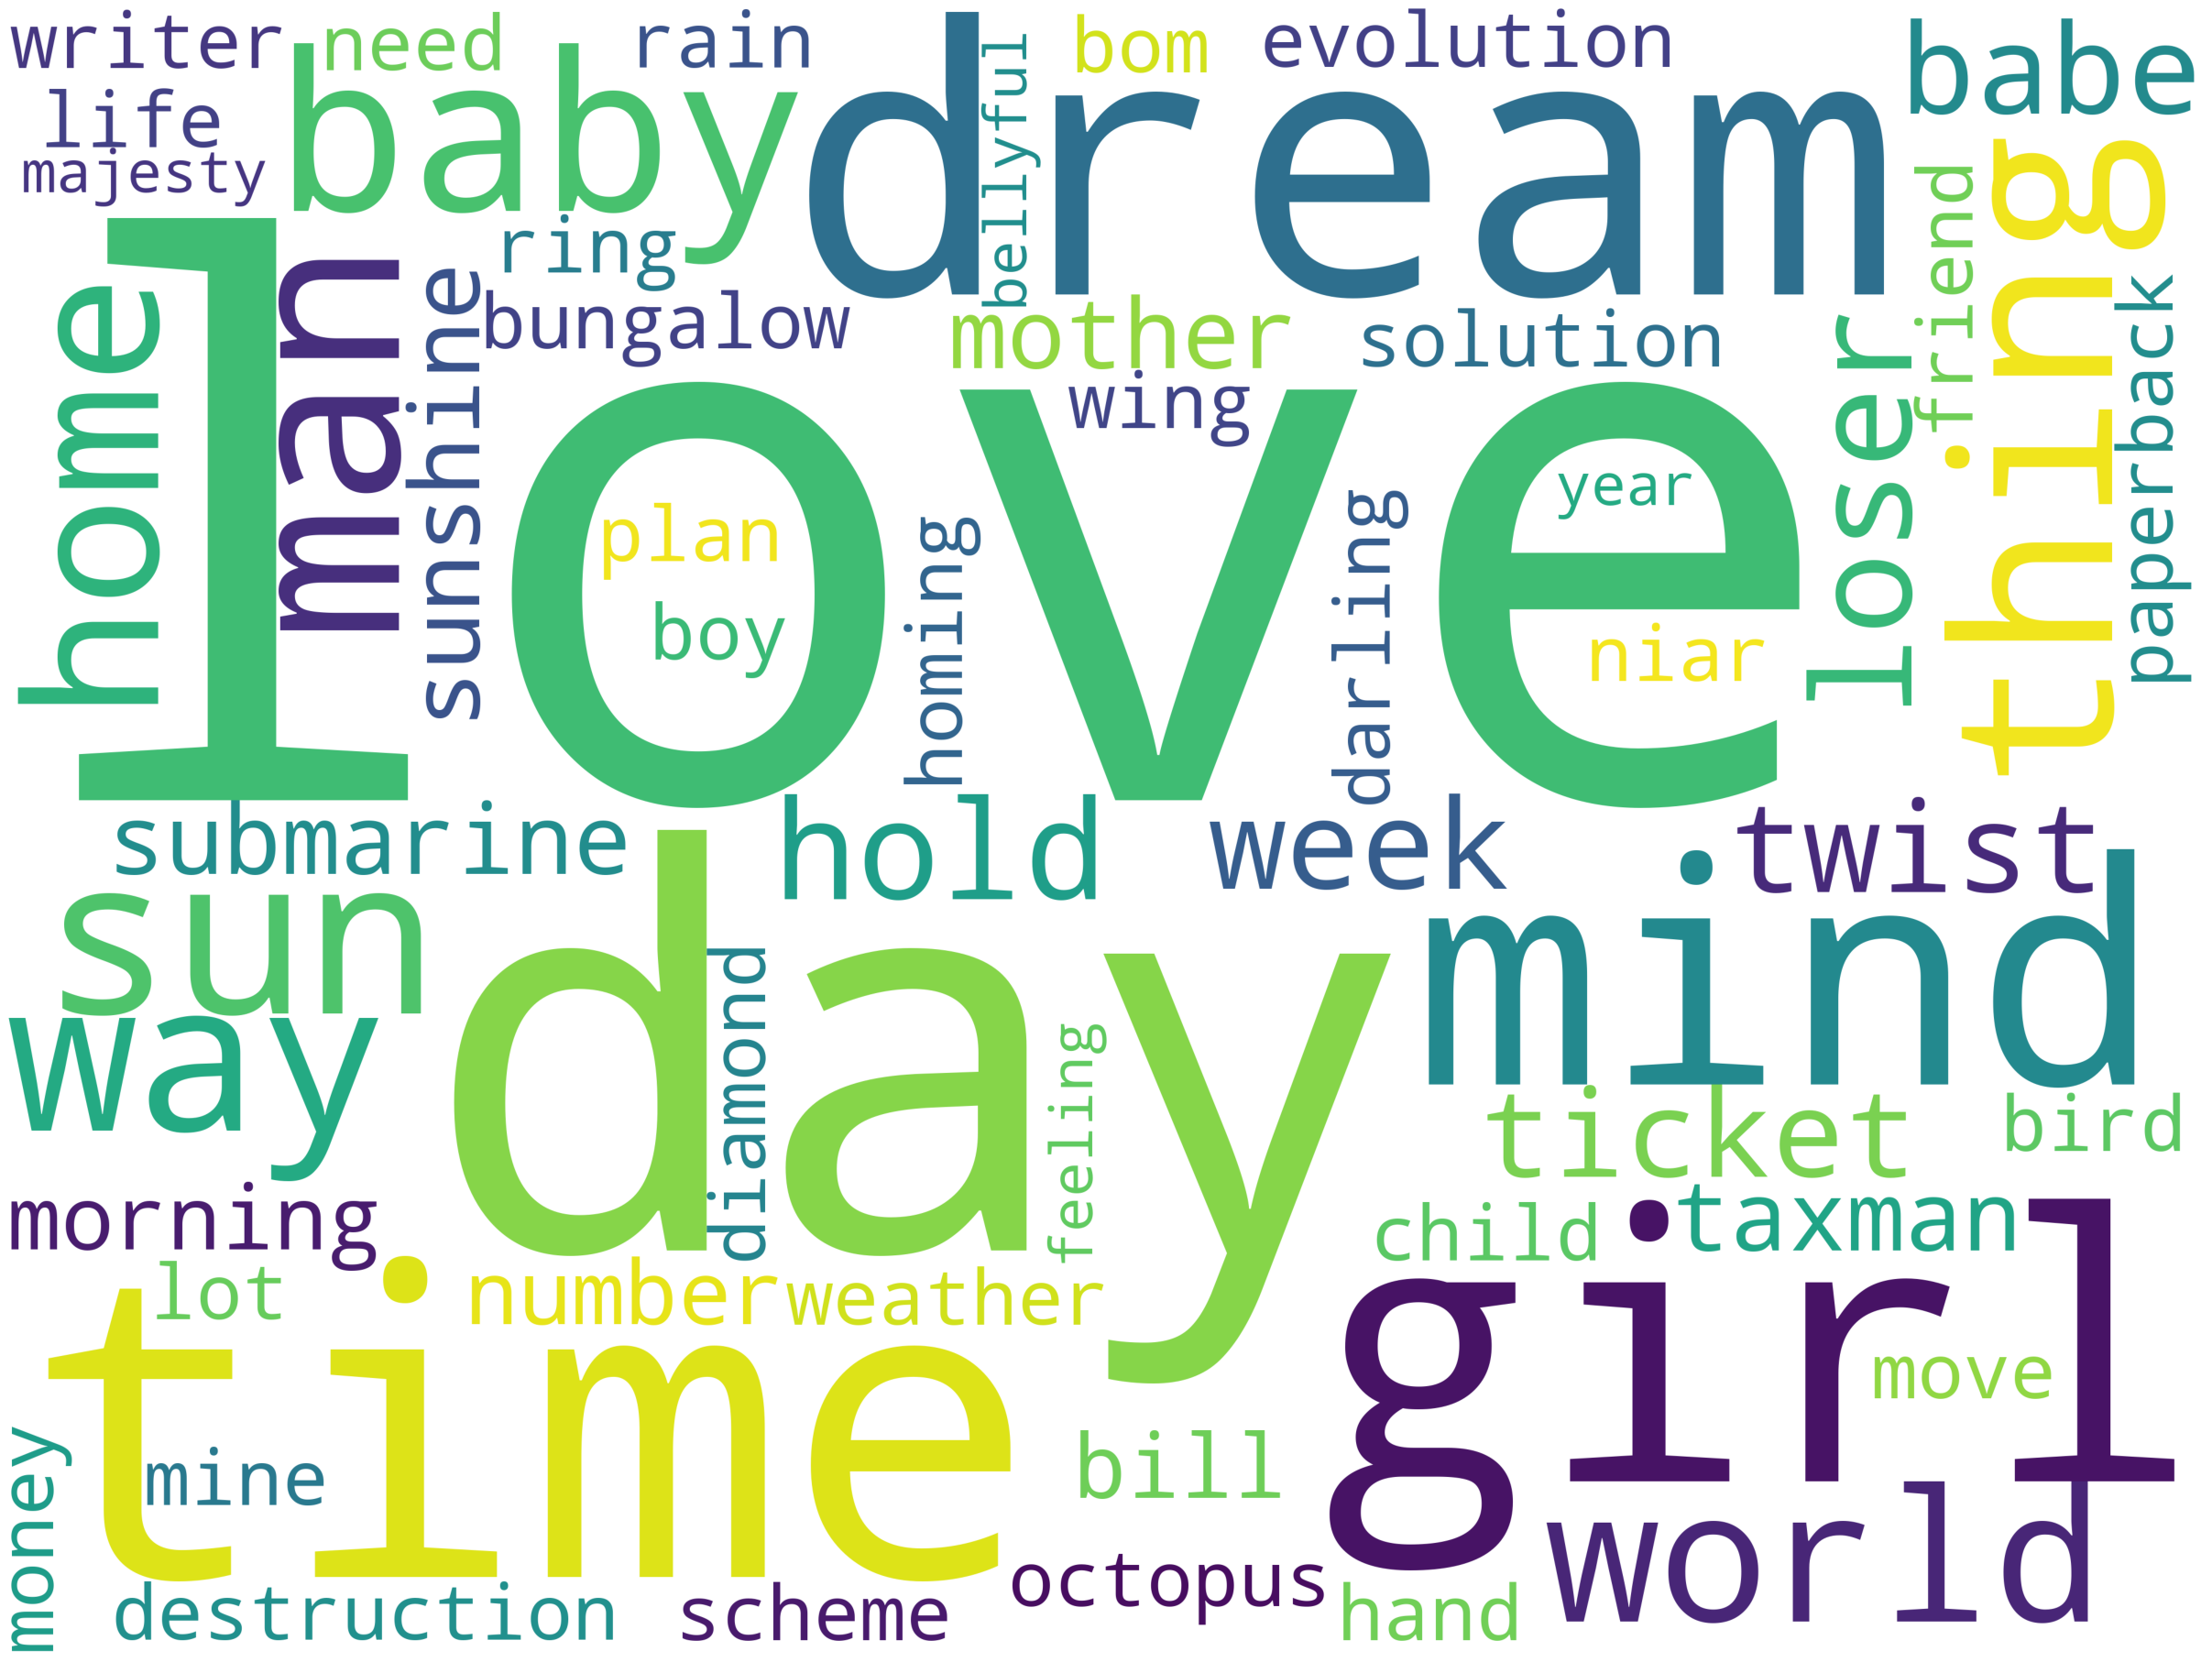

In [64]:
#Creando nube de palabras para los sustantivos
wordcloud(top_nouns, max_words=100)

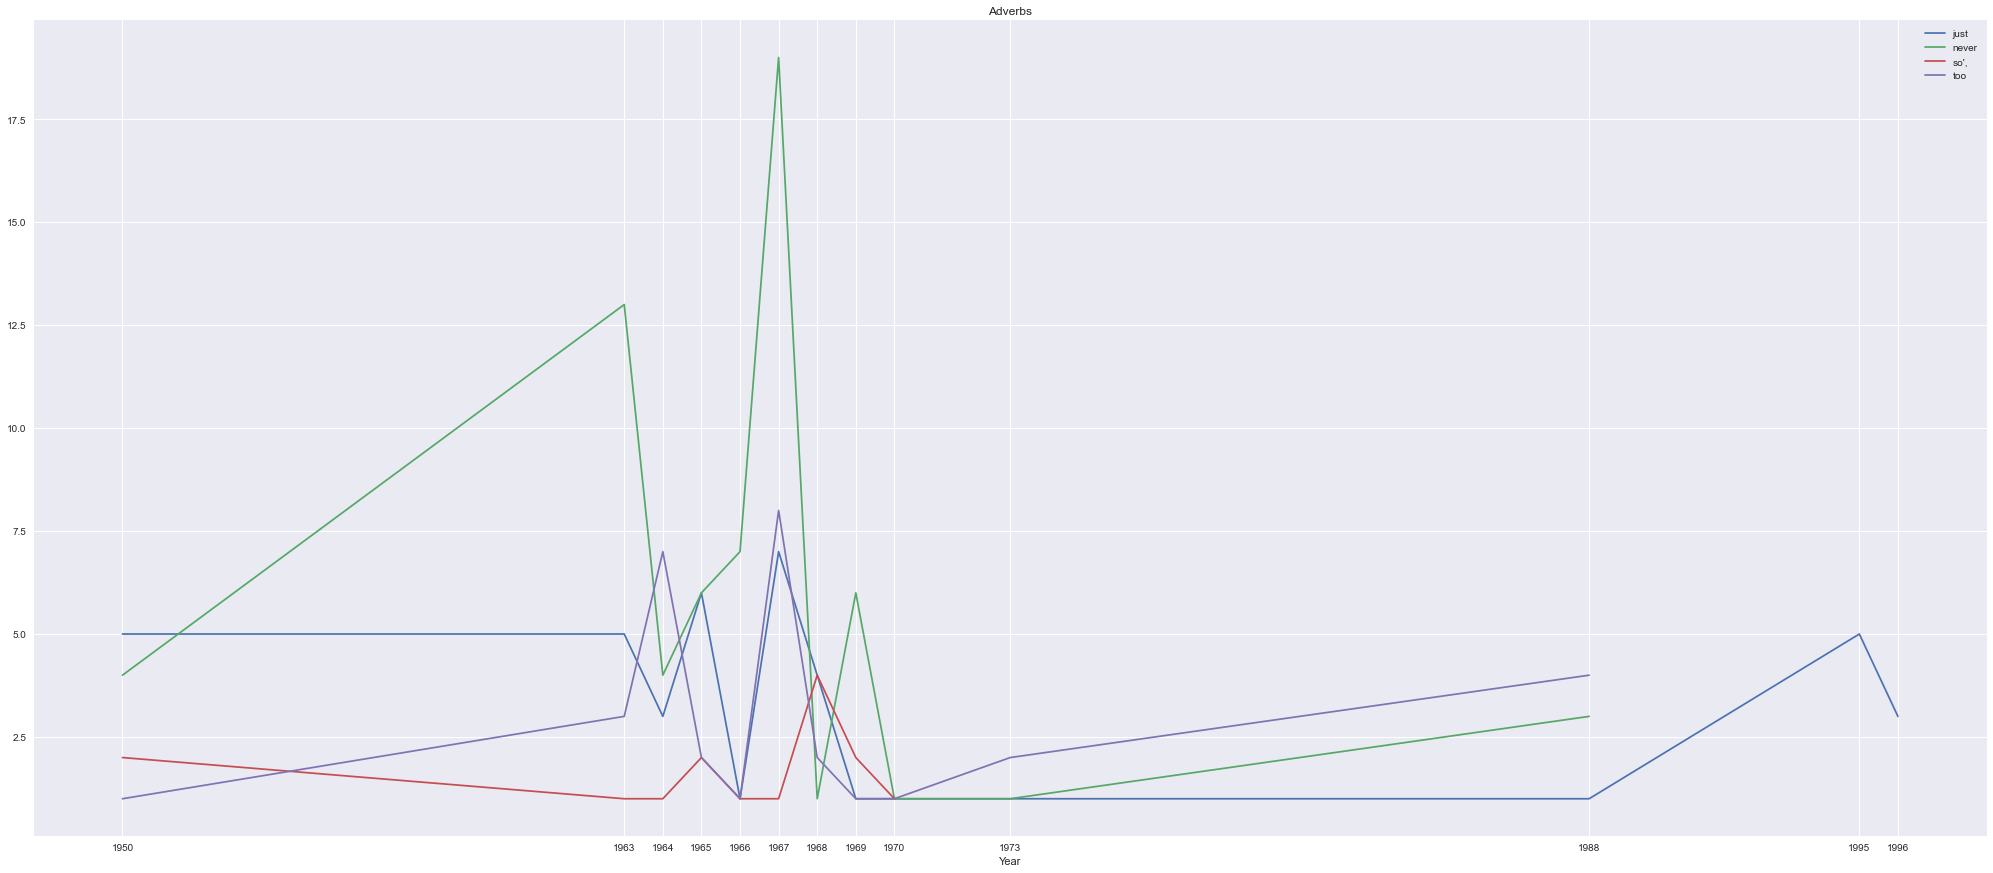

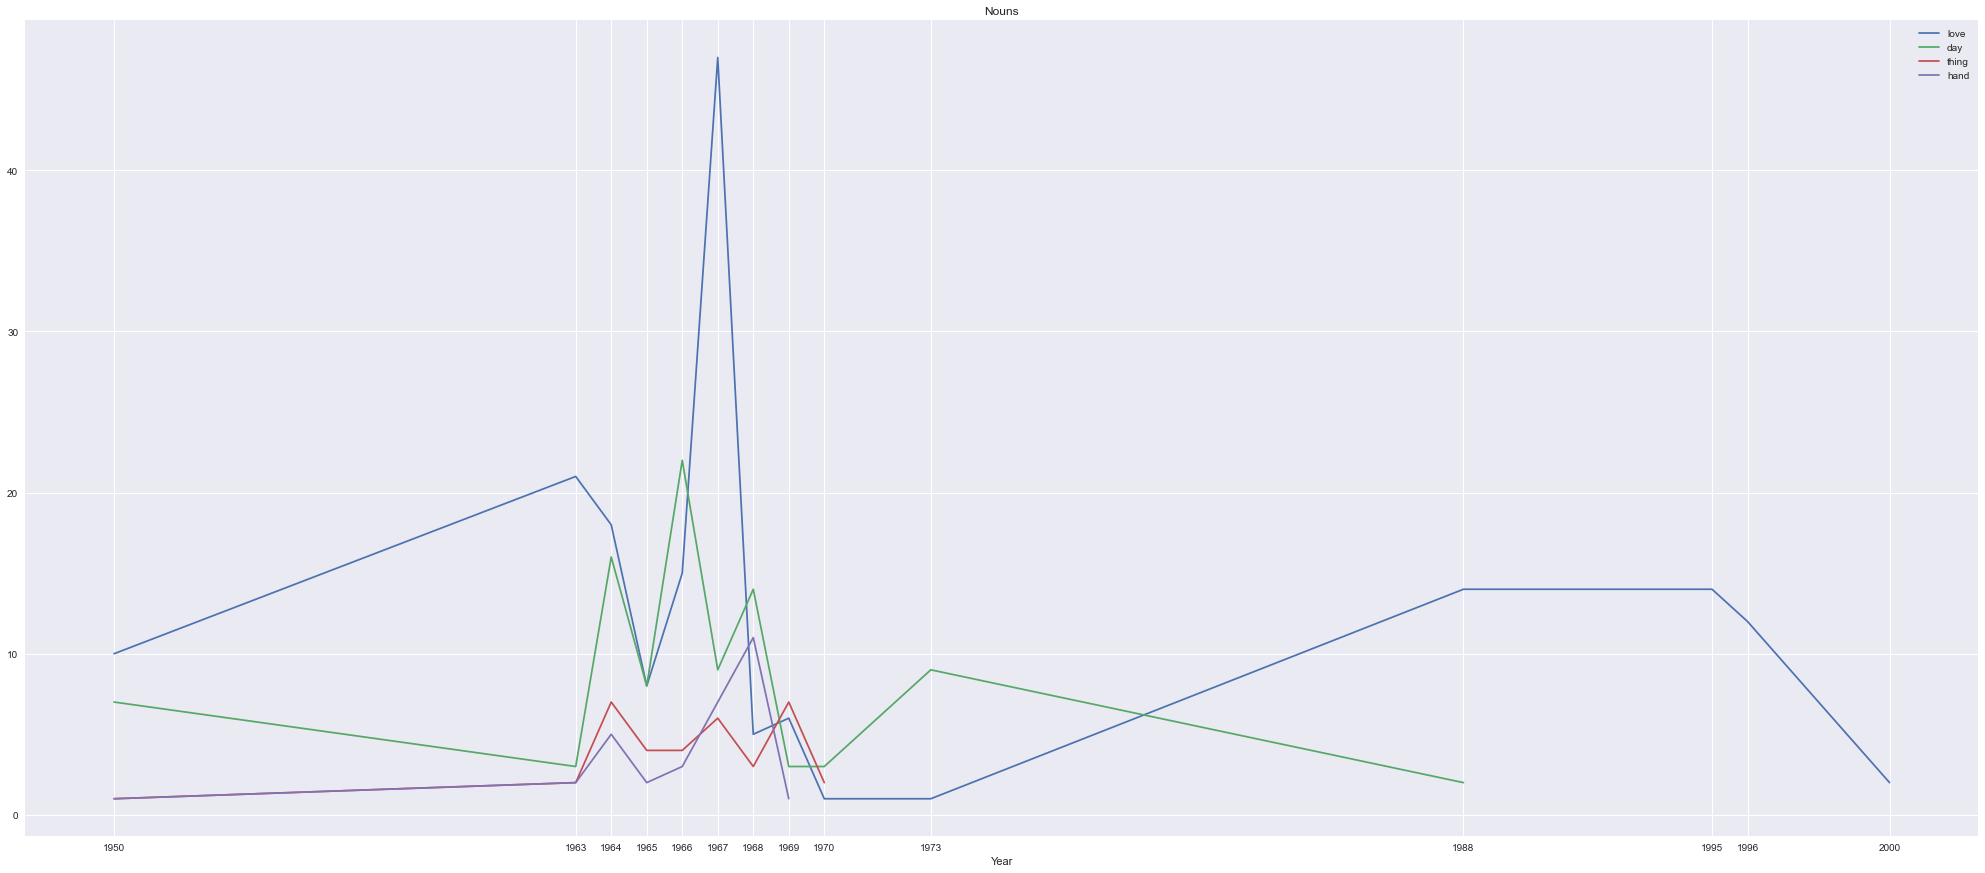

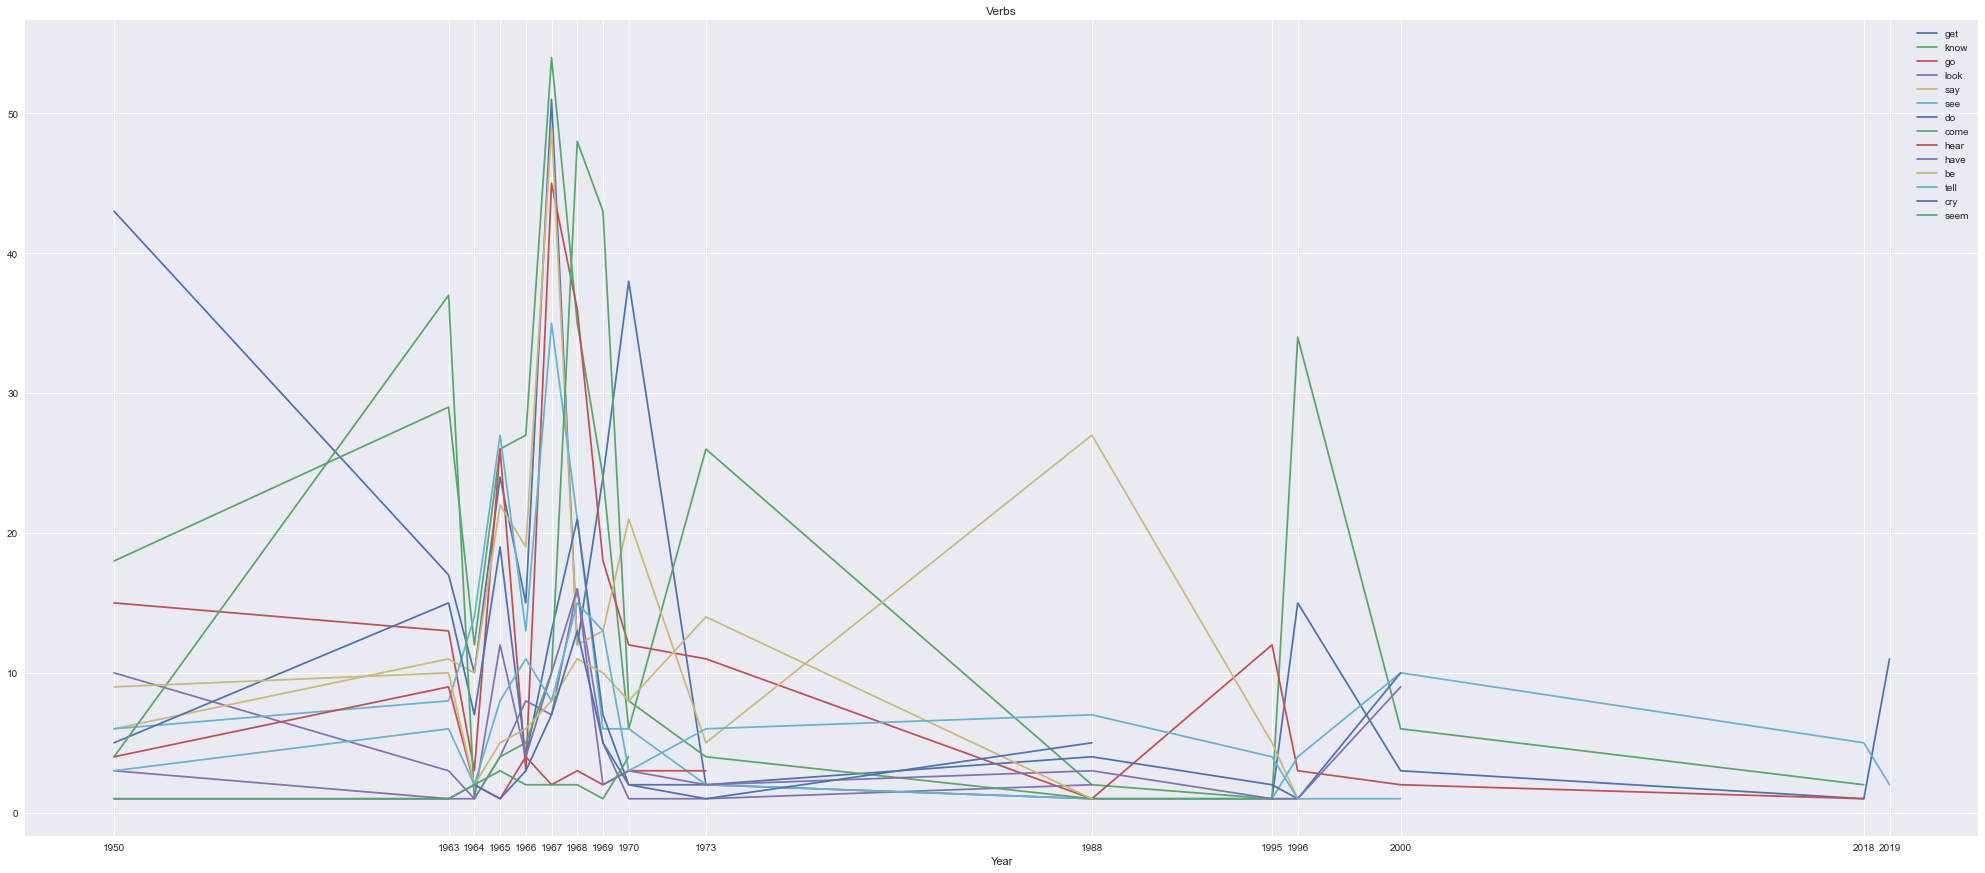

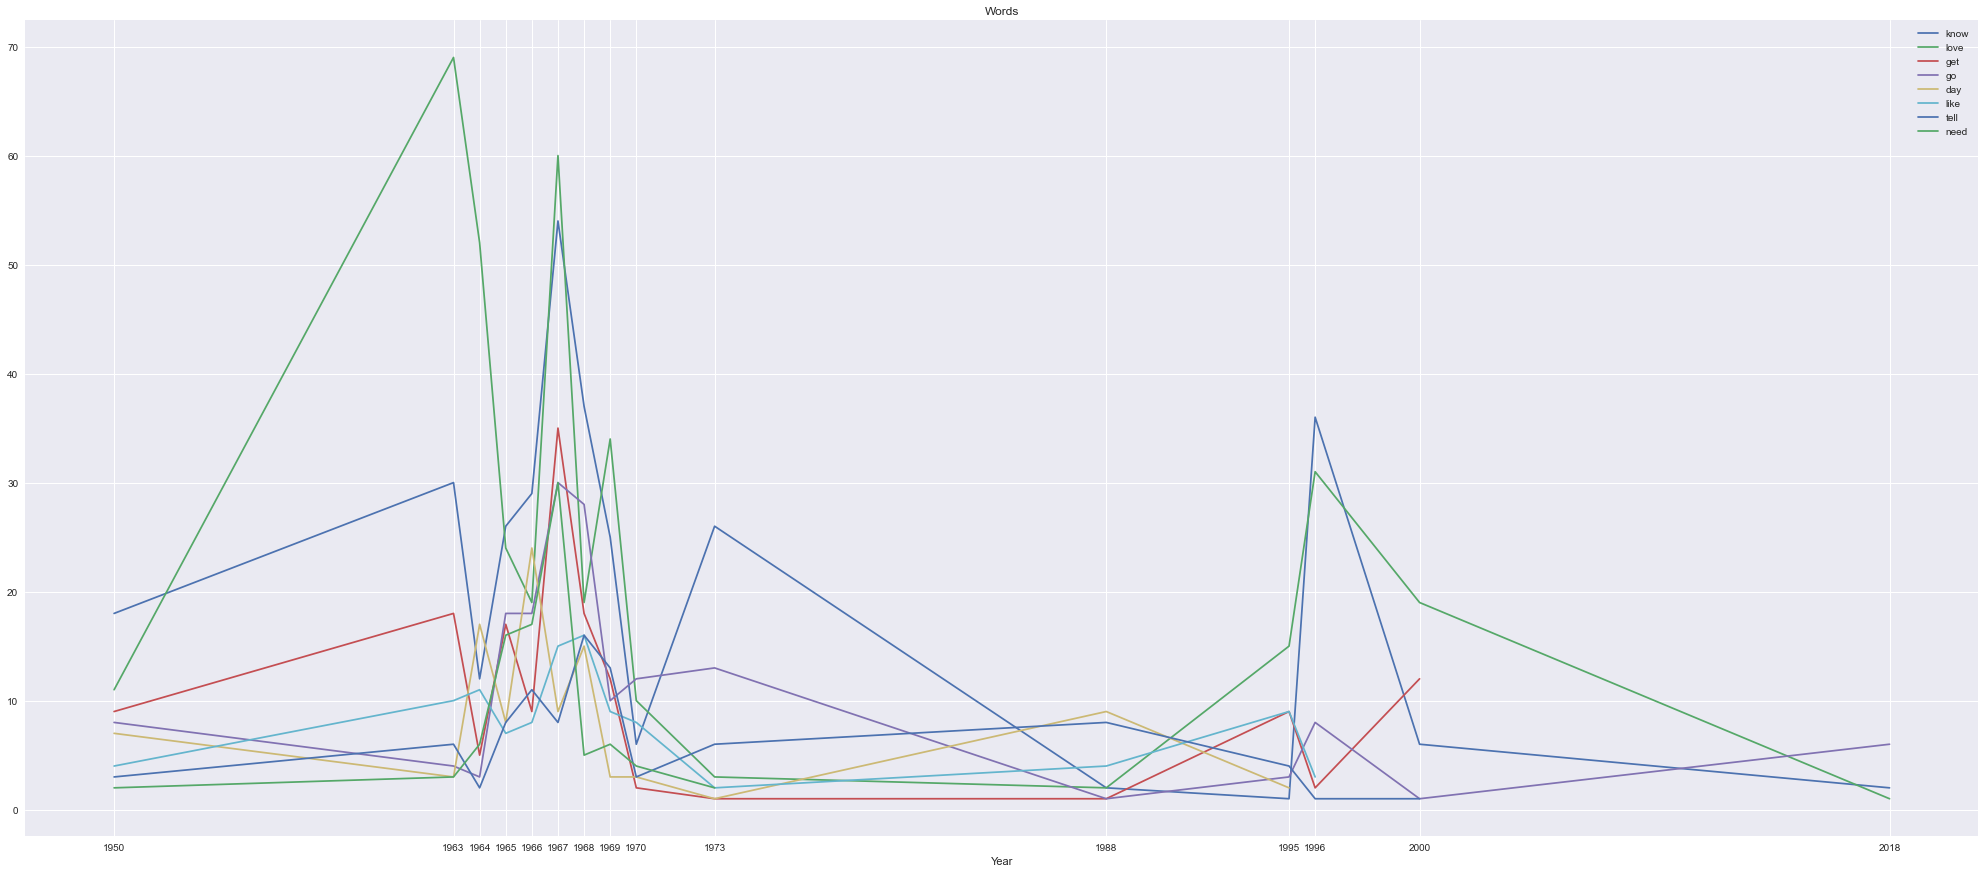

In [65]:
#Graficando toda la información recabada hasta este momento
common_adverb_counts.plot(figsize=(35,15), title="Adverbs", grid="true", xticks=common_adverb_counts.index)
common_noun_counts.plot(figsize=(35,15), title="Nouns", grid="true", xticks=common_noun_counts.index)
common_verb_counts.plot(figsize=(35,15), title="Verbs", grid="true", xticks=common_verb_counts.index)
common_word_counts.plot(figsize=(35,15), title="Words", grid="true", xticks=common_word_counts.index)
plt.show()

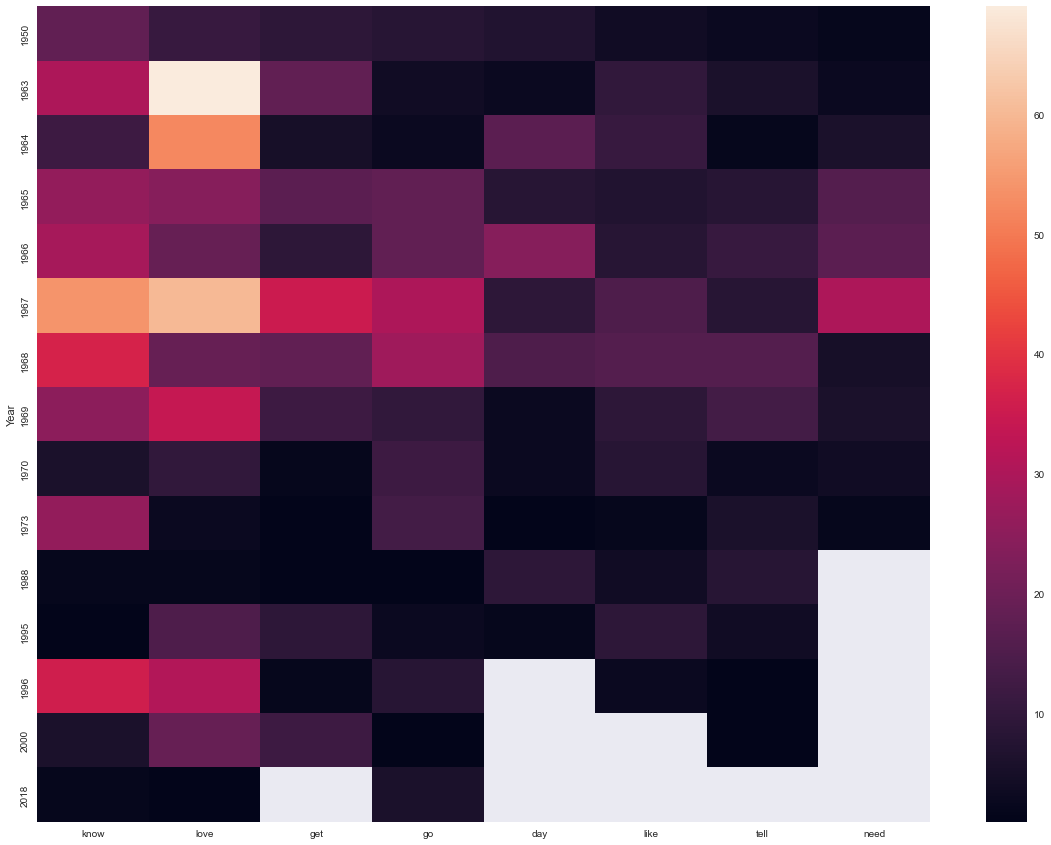

In [66]:
#Mostrando mapa de calor por año para las palabras comunes
#No todos los años tienen apariciones de ciertas palabras por lo que se muestran en color gris 
plt.figure(figsize=(20,15))
sns.heatmap(data=common_word_counts)
plt.show()

## Análisis de Sentimientos


In [67]:
#Se utiliza un archivo de malas palabras obtenido de facebook
#https://stackoverflow.com/questions/34399172/why-does-my-python-code-print-the-extra-characters-%C3%AF-when-reading-from-a-tex/34399309
#Se crea una lista de malas palabras separadas por comas, no sin antes agregar espacios antes y despues de cada palabra
# de no realizar esta acción, puede dar paso a muchos falsos positivos porque detecta elementos en medio de las palabras
bad_word_file = 'facebook-bad-words-list_comma-separated-text-file_2021_01_18.txt'
with open(bad_word_file, encoding='utf-8-sig') as f:
    bad_words_list = f.read().split(",")
bad_words_list_definitive = []
for bad_word in bad_words_list:
    bad_words_list_definitive.append(bad_word+" ")
bad_words_list = bad_words_list_definitive
print(bad_words_list)

[' 4r5e ', ' 5h1t ', ' 5hit ', ' a55 ', ' anal ', ' anus ', ' ar5e ', ' arrse ', ' arse ', ' ass ', ' ass-fucker ', ' asses ', ' assfucker ', ' assfukka ', ' asshole ', ' assholes ', ' asswhole ', ' a_s_s ', ' b!tch ', ' b00bs ', ' b17ch ', ' b1tch ', ' ballbag ', ' balls ', ' ballsack ', ' bastard ', ' beastial ', ' beastiality ', ' bellend ', ' bestial ', ' bestiality ', ' bi+ch ', ' biatch ', ' bitch ', ' bitcher ', ' bitchers ', ' bitches ', ' bitchin ', ' bitching ', ' bloody ', ' blow job ', ' blowjob ', ' blowjobs ', ' boiolas ', ' bollock ', ' bollok ', ' boner ', ' boob ', ' boobs ', ' booobs ', ' boooobs ', ' booooobs ', ' booooooobs ', ' breasts ', ' buceta ', ' bugger ', ' bum ', ' bunny fucker ', ' butt ', ' butthole ', ' buttmuch ', ' buttplug ', ' c0ck ', ' c0cksucker ', ' carpet muncher ', ' cawk ', ' chink ', ' cipa ', ' cl1t ', ' clit ', ' clitoris ', ' clits ', ' cnut ', ' cock ', ' cock-sucker ', ' cockface ', ' cockhead ', ' cockmunch ', ' cockmuncher ', ' cocks ',

In [68]:
#Obteniendo longitud de la lista
len(bad_words_list)

1011

In [69]:
#Analiza el corpus de cada canción en busca de malas palabras
bad_words_per_song = []
for i in range (0, len(prepared_songs_dataset)):
    bad_words_found = []
    #print("\n" + prepared_songs_dataset.iloc[i]['Corpus'] + "\n")
    for bad_word in bad_words_list:
        if bad_word in prepared_songs_dataset.iloc[i]['Corpus']:
            print("Found bad word in record: {}".format(i), end="\r")
            bad_words_found.append(bad_word)
            print("\n" + bad_word)
    bad_words_per_song.append(bad_words_found)

Found bad word in record: 0
 stupid 
Found bad word in record: 61
 bloody 
Found bad word in record: 61
 stupid 
Found bad word in record: 80
 butt 
Found bad word in record: 84
 sexy 
Found bad word in record: 88
 bitch 
Found bad word in record: 88
 bloody 
Found bad word in record: 90
 damn 
Found bad word in record: 107
 suck 
Found bad word in record: 116
 cracker 
Found bad word in record: 141
 fucking 
Found bad word in record: 141
 hell 
Found bad word in record: 149
 wet dream 


In [70]:
#Guardando información en el dataset
prepared_songs_dataset['Bad Words'] = bad_words_per_song
#Guardando en csv
prepared_songs_dataset.to_csv("final_prepped_dataset.csv")

In [71]:
#Obteniendo el numero de malas palabras por canción
# Se almacena en el dataset y en un csv
num_bad_words = []
for i in range (0, len(prepared_songs_dataset)):
    num_bad_words.append(len(prepared_songs_dataset.iloc[i]['Bad Words']))
prepared_songs_dataset['# Bad Words'] = num_bad_words
prepared_songs_dataset.to_csv("final_prepped_dataset.csv")

In [72]:
#Leyendo csv (Checkpoint)
prepared_songs_dataset = pd.read_csv("final_prepped_dataset.csv", index_col=0)

In [73]:
#Mostrando dataset
prepared_songs_dataset.head(3)

artist                    title decade  date  \
55   The Beatles             I’m So Tired    50s  1950   
147  The Beatles              I’m a Loser    50s  1950   
112  The Beatles  I’m Looking Through You    50s  1950   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       lyric  \
55   so tired i haven't slept a wink  so tired my mind is on the blink i wonder should i get up and fix myself a drink no no no    so tired i don't know what to do  so tired my mind is set on you i wonder should i call you but i know what you would do   you'd say  putting you on but it's no joke it's doing me harm you know i can't sleep i can't stop my brain you know it's three weeks  going insane you know i'd give you everything  got for a little peace of mind    so tired  feeling so upset although  so tired i'll have another cigarette and curse sir walter raleigh he was such a stupid git   you'd say  putting you on but it's no joke it's doing me harm you know i can't sleep i can't stop my brain you know it's three weeks  going insane you know i'd give you everything  got for a little peace of mind i'd give you everything  got for a little peace of mind i'd give you everything  got for a little peace of mind  monsieur monsieur monsieur how about another one   
147                                                                                                                                                             a loser  a loser and  not what i appear to be   of all the love i have won or have lost there is one love i should never have crossed she was a girl in a million my friend i should have known she would win in the end    a loser and i lost someone who's near to me  a loser and  not what i appear to be  although i laugh and i act like a clown beneath this mask i am wearing a frown my tears are falling like rain from the sky is it for her or myself that i cry    a loser and i lost someone who's near to me  a loser and  not what i appear to be harmonica and guitar s   what have i done to deserve such a fate i realise i have left it too late and so it's true pride comes before a fall  telling you so that you won't lose all    a loser and i lost someone who's near to me  a loser and  not what i appear to be   
112                  looking through you where did you go i thought i knew you what did i know you don't look different but you have changed  looking through you you're not the same   your lips are moving i cannot hear your voice is soothing but the words aren't clear you don't sound different  learned the game  looking through you you're not the same   why tell me why did you not treat me right love has a nasty habit of disappearing overnight   you're thinking of me the same old way you were above me but not today the only difference is you're down there  looking through you and you're nowhere   why tell me why did you not treat me right love has a nasty habit of disappearing overnight   looking through you where did you go i thought i knew you what did i know you don't look different but you have changed  looking through you you're not

#### Análisis por año

In [74]:
#Obteniendo el número de malas palabras por año, el número de canciones con malas palabras y el número de canciones por año
summary_bad_words = pd.DataFrame()
for i in range (0, len(years)):
    bad_words_per_year = sum(prepared_songs_dataset['# Bad Words'][prepared_songs_dataset['date'] == years[i]])
    songs_with_bad_words_per_year = sum(prepared_songs_dataset['# Bad Words'][prepared_songs_dataset['date'] == years[i]] > 0)

    row = {
        "Year": years[i],
        "Bad Words": bad_words_per_year,
        "Songs with Bad Words":songs_with_bad_words_per_year
    }
    summary_bad_words = summary_bad_words.append(row, ignore_index = True)
summary_bad_words['Year'] = summary_bad_words['Year'].astype(int)
summary_bad_words['Songs Per Year'] = characteristics['decade'].values.tolist()
summary_bad_words.set_index('Year', inplace=True)
summary_bad_words

Bad Words  Songs with Bad Words  Songs Per Year
Year                                                 
1970        0.0                   0.0               8
1965        0.0                   0.0              11
1969        2.0                   2.0               6
2000        2.0                   1.0              14
1967        2.0                   1.0              12
1968        5.0                   4.0              25
1966        0.0                   0.0              25
2021        1.0                   1.0              18
1973        0.0                   0.0              10
1963        0.0                   0.0               2
1950        1.0                   1.0               2
1964        0.0                   0.0               1
2018        0.0                   0.0               1
2019        0.0                   0.0              10
1996        0.0                   0.0               2
1988        0.0                   0.0               1
1995        0.0                   0.0               2

In [75]:
#Mostrando malas palabras para el elemento 135, sería la canción "Hey Jude"
prepared_songs_dataset.iloc[135]['Bad Words']

'[]'

In [76]:
#Ordenando por año
summary_bad_words.sort_values('Year', inplace=True)
summary_bad_words

Bad Words  Songs with Bad Words  Songs Per Year
Year                                                 
1950        1.0                   1.0               2
1963        0.0                   0.0               2
1964        0.0                   0.0               1
1965        0.0                   0.0              11
1966        0.0                   0.0              25
1967        2.0                   1.0              12
1968        5.0                   4.0              25
1969        2.0                   2.0               6
1970        0.0                   0.0               8
1973        0.0                   0.0              10
1988        0.0                   0.0               1
1995        0.0                   0.0               2
1996        0.0                   0.0               2
2000        2.0                   1.0              14
2018        0.0                   0.0               1
2019        0.0                   0.0              10
2021        1.0                   1.0              18

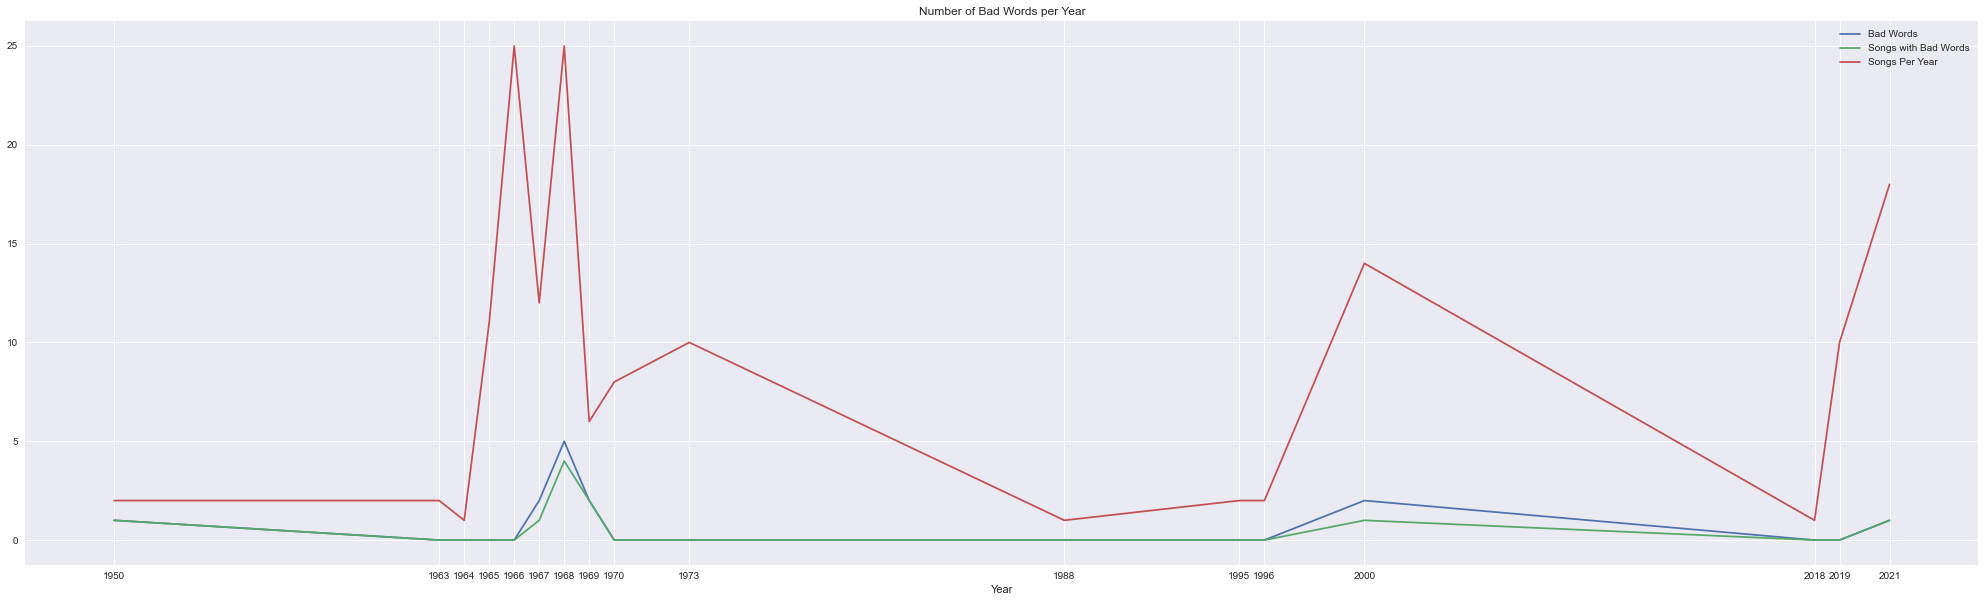

In [77]:
#Gráfica de relación entre el año y el numero de malas palabras
summary_bad_words.plot(title = "Number of Bad Words per Year", figsize=(35,10), grid = True, xticks=summary_bad_words.index)
plt.show()

#### Análisis por décadas 

In [78]:
#Obteniendo las décadas que abarcan las canciones
decades = list(set(prepared_songs_dataset['decade'].tolist()))

In [79]:
#Descartando décadas sin actividad
full_decades = ['50s','60s','70s', '80s', '90s', '00s', '10s']
included_decades = ['50s','60s','70s', '80s', '90s', '00s', '10s']
for decade in full_decades:
    if decade not in decades:
        included_decades.remove(decade)
        
print(included_decades)
included_decades.insert(0,'words') #Se utiliza en el conteo de palabras
print(included_decades)

['50s', '60s', '70s', '80s', '90s', '00s', '10s']
['words', '50s', '60s', '70s', '80s', '90s', '00s', '10s']


In [80]:
#Función que obtiene palabras únicas
def unique(list1): 
    unique_list = [] 
      
    for x in list1: 
        if x not in unique_list: 
            unique_list.append(x) 
    
    return unique_list

In [81]:
#Descarga diccionarios de nltk, sólo es necesario hacerlo una vez, por eso están comentados
#nltk.download("stopwords")
#nltk.download('wordnet')

#Almacena las palabras únicas de cada canción
import string
words = []
prepared_songs_dataset = prepared_songs_dataset.reset_index(drop=True)
for word in prepared_songs_dataset['lyric'].tolist():
    words.append(unique(lyrics_to_words(word).split()))

#Crea una nueva columna en el dataset con las palabras únicas
prepared_songs_dataset['words'] = words

In [82]:
#Crea un nuevo dataframe de todas las palabras en las letras y sus décadas
set_words = []
set_decades = []

for i in prepared_songs_dataset.index:
    for word in prepared_songs_dataset['words'].iloc[i]:
        set_words.append(word)
        set_decades.append(prepared_songs_dataset['decade'].iloc[i])

#Crea nuevo dataframe con las palabras y sus decadas
words_df = pd.DataFrame({'words':set_words,'decade':set_decades})

In [83]:
#Cotabiliza la frecuencia de cada palabra    
cv = CountVectorizer()

#Crea dataframe donde se guarda cuantas veces se usó una palabra por década
text_cv = cv.fit_transform(words_df['words'].iloc[:])
data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names_out())
data_cv['decade'] = words_df['decade']

#Crea dataframe con la suma de la frecuencia de una palabra por década
vect_words = data_cv.groupby('decade').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns ={'index':'words'})
vect_words = vect_words.rename_axis(columns='')

#Se guarda la información en un csv
vect_words.to_csv('words.csv',index=False)

#Se ordena por década (ascendente)
vect_words = vect_words[included_decades]

In [84]:
#Se muestran las primeras cinco palabras 
vect_words.head()

words  50s  60s  70s  80s  90s  00s  10s
0      able    0    1    0    0    0    0    0
1    aboard    0    1    0    0    0    0    0
2  accident    0    1    0    0    0    0    0
3      ache    0    1    0    0    0    0    0
4     acorn    0    0    0    0    0    1    0

In [85]:
#Funciones para Mostrar estadísticas por década 
def words_stats(df,main_df):
    unique_words = []
    total_words = []
    total_news = []
    years = []
    for value in df.columns[1:]:
         unique_words.append(np.count_nonzero(df[value]))
         total_words.append(sum(df[value]))
         years.append(str(value))
         total_news.append(main_df['decade'][main_df['decade']==value].count())
    
    data = pd.DataFrame({'decade':years,'unique words':unique_words,'total words':total_words,'total songs':total_news})
    data['words per songs'] = round(data['total words'] / data['total songs'],0)
    data['words per songs'] = data['words per songs'].astype('int')
    return data

def plot_freq_words(df,decade,n_words):
    
    top_words = df.sort_values([decade],ascending=False).head(n_words)

    fig = plt.figure(figsize=(15,8))
    plt.plot(top_words['words'],top_words[df.columns[1]])
    plt.plot(top_words['words'],top_words[df.columns[2]])
    plt.plot(top_words['words'],top_words[df.columns[3]])
    plt.plot(top_words['words'],top_words[df.columns[4]])

    plt.legend(df.columns[1:].tolist())
    plt.title(f"Palabras más frecuentes en los {decade} comparadas con otras décadas",fontsize=14)
    plt.xlabel(f'Palabras más frecuentes en los {decade}',fontsize=12)
    plt.ylabel('Frecuencia',fontsize=12)
    plt.xticks(fontsize=12,rotation=20)
    plt.yticks(fontsize=12)
    plt.savefig("lineplot.png",format="png", bbox_inches='tight')
    plt.show()

In [86]:
#Llamando a la función para generar las estadísticas por década
words_stats(vect_words,prepared_songs_dataset)

decade  unique words  total words  total songs  words per songs
0    50s           245          318            8               40
1    60s          1732         4629          111               42
2    70s           340          488           12               41
3    80s            55           56            2               28
4    90s            57           60            2               30
5    00s           319          417           10               42
6    10s           149          179            5               36

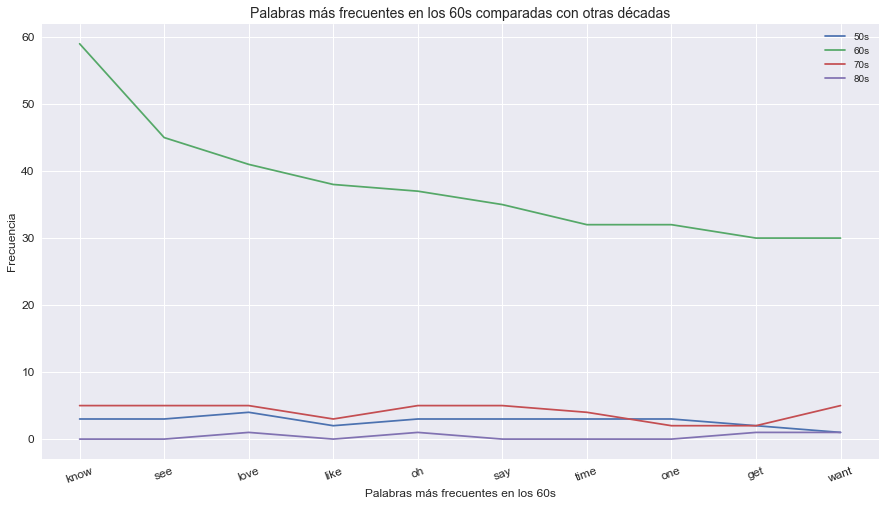

In [87]:
#Gráfica que muestra las palabras más comunes en los 60s y su comportamiento en otras décadas
plot_freq_words(vect_words,'60s',10)

In [88]:
#Función que muestras las palabras más comunes para cierta década
def unique_decade_words(df,decade,n_words):
    periods = []
    unique_words = []
    top_words = df.sort_values([decade],ascending=False).head(n_words).reset_index(drop=True)

    for d in top_words.columns[1:]:
        if d != decade:
            periods.append(d)

    for i in top_words.index:
        if top_words[periods[0]].iloc[i]<top_words[decade].min():
            if top_words[periods[1]].iloc[i]<top_words[decade].min():
                if top_words[periods[2]].iloc[i]<top_words[decade].min():
                    unique_words.append(top_words['words'].iloc[i])
    return unique_words

In [89]:
#Mostrando las 10 palabras más comunes de los 60's
unique_decade_words(vect_words,'60s',10)

['know', 'see', 'love', 'like', 'oh', 'say', 'time', 'one', 'get', 'want']

In [90]:
#Descarga el modelo vader para análisis de sentimientos, sólo es necesario hacerlo una vez, por eso está comentado
#nltk.download('vader_lexicon')

#Análisis de sentimiento utilizando el modelo VADER Sentiment Intensinty

negative = []
neutral = []
positive = []
compound = []

#Inicializando el modelo
sid = SentimentIntensityAnalyzer()

for i in prepared_songs_dataset.index:
    scores = sid.polarity_scores(prepared_songs_dataset['lyric'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])

#Creando columnas para cada uno de los "sentimientos"
prepared_songs_dataset['negative'] = negative
prepared_songs_dataset['neutral'] = neutral
prepared_songs_dataset['positive'] = positive
prepared_songs_dataset['compound'] = compound

In [91]:
#Mostrando dataset con análisis de sentimientos
prepared_songs_dataset.head(3)

artist                    title decade  date  \
0  The Beatles             I’m So Tired    50s  1950   
1  The Beatles              I’m a Loser    50s  1950   
2  The Beatles  I’m Looking Through You    50s  1950   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     lyric  \
0  so tired i haven't slept a wink  so tired my mind is on the blink i wonder should i get up and fix myself a drink no no no    so tired i don't know what to do  so tired my mind is set on you i wonder should i call you but i know what you would do   you'd say  putting you on but it's no joke it's doing me harm you know i can't sleep i can't stop my brain you know it's three weeks  going insane you know i'd give you everything  got for a little peace of mind    so tired  feeling so upset although  so tired i'll have another cigarette and curse sir walter raleigh he was such a stupid git   you'd say  putting you on but it's no joke it's doing me harm you know i can't sleep i can't stop my brain you know it's three weeks  going insane you know i'd give you everything  got for a little peace of mind i'd give you everything  got for a little peace of mind i'd give you everything  got for a little peace of mind  monsieur monsieur monsieur how about another one   
1                                                                                                                                                             a loser  a loser and  not what i appear to be   of all the love i have won or have lost there is one love i should never have crossed she was a girl in a million my friend i should have known she would win in the end    a loser and i lost someone who's near to me  a loser and  not what i appear to be  although i laugh and i act like a clown beneath this mask i am wearing a frown my tears are falling like rain from the sky is it for her or myself that i cry    a loser and i lost someone who's near to me  a loser and  not what i appear to be harmonica and guitar s   what have i done to deserve such a fate i realise i have left it too late and so it's true pride comes before a fall  telling you so that you won't lose all    a loser and i lost someone who's near to me  a loser and  not what i appear to be   
2                  looking through you where did you go i thought i knew you what did i know you don't look different but you have changed  looking through you you're not the same   your lips are moving i cannot hear your voice is soothing but the words aren't clear you don't sound different  learned the game  looking through you you're not the same   why tell me why did you not treat me right love has a nasty habit of disappearing overnight   you're thinking of me the same old way you were above me but not today the only difference is you're down there  looking through you and you're nowhere   why tell me why did you not treat me right love has a nasty habit of disappearing overnight   looking through you where did you go i thought i knew you what did i know you don't look different but you have changed  looking through you you're not the same    o

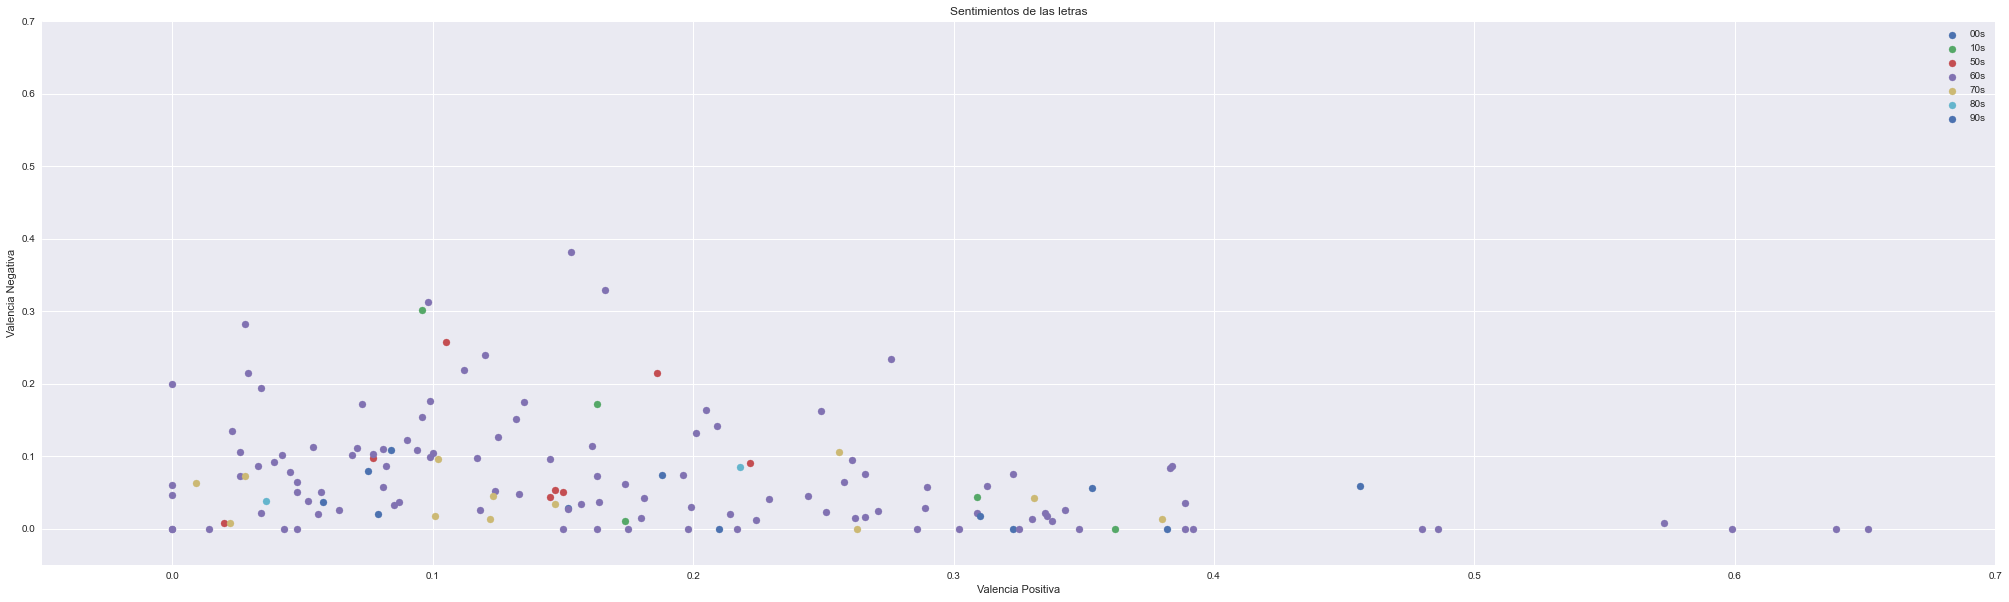

In [92]:
#Graficando los sentimientos para cada canción clasificada en su década
for name, group in prepared_songs_dataset.groupby('decade'):
    plt.scatter(group['positive'],group['negative'],label=name)
    plt.legend(fontsize=10)

plt.xlim([-0.05,0.7])
plt.ylim([-0.05,0.7])

plt.title("Sentimientos de las letras")
plt.xlabel('Valencia Positiva')
plt.ylabel('Valencia Negativa')
plt.show()

In [93]:
#Agrupando por década y obteniendo promedio
#Se guarda en csv
means_df = prepared_songs_dataset.groupby(['decade']).mean()
means_df.to_csv("sentiment_analysis_decade.csv")
means_df 

date  Word Counts  Unique Word Counts  # Bad Words  negative  \
decade                                                                        
00s     2000.000000   193.600000           68.300000     0.200000  0.040800   
10s     2019.400000   186.600000           61.200000     0.200000  0.105400   
50s     1950.000000   169.875000           67.000000     0.125000  0.101875   
60s     1966.630631   181.054054           66.612613     0.081081  0.073703   
70s     1970.500000   184.250000           63.166667     0.000000  0.042333   
80s     1988.000000   120.500000           51.000000     0.000000  0.061500   
90s     1995.500000   164.500000           55.000000     0.000000  0.036500   

         neutral  positive  compound  
decade                                
00s     0.758400  0.200700  0.706550  
10s     0.674000  0.220800  0.253140  
50s     0.766875  0.131500  0.286988  
60s     0.738225  0.188045  0.383680  
70s     0.800417  0.157000  0.576842  
80s     0.811500  0.127000  0.314100  
90s     0.632500  0.331500  0.995650

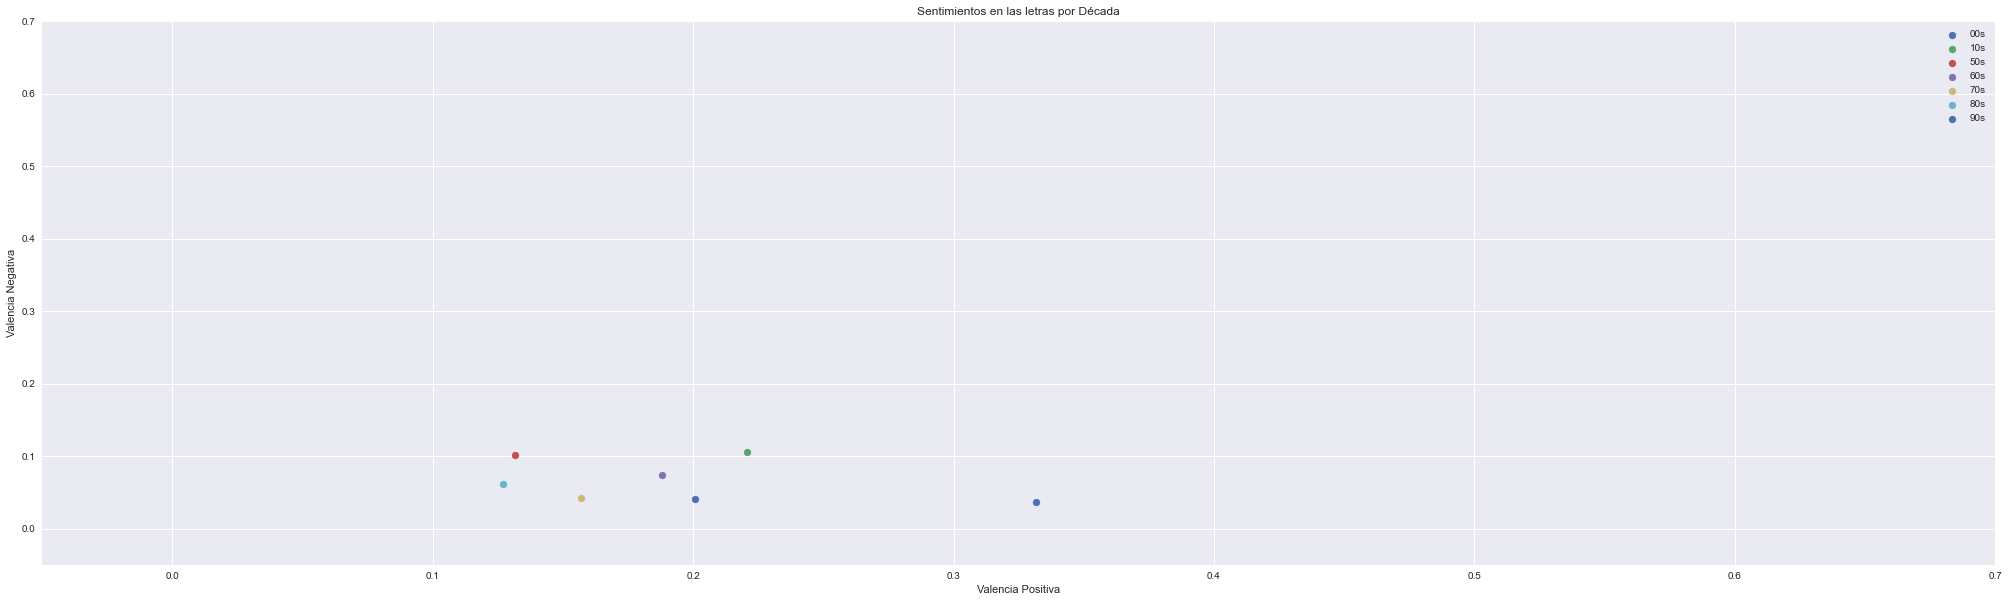

In [94]:
#Graficando sentimientos por década
for name, group in means_df.groupby('decade'):
    plt.scatter(group['positive'],group['negative'],label=name)
    plt.legend()

plt.xlim([-0.05,0.7])
plt.ylim([-0.05,0.7])
plt.title("Sentimientos en las letras por Década")
plt.xlabel('Valencia Positiva')
plt.ylabel('Valencia Negativa')

plt.show()